<a href="https://colab.research.google.com/github/aswinigh/Cloth-simulation/blob/master/ML_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [138]:
import pandas as pd
df_x = pd.read_csv('/content/drive/My Drive/MLProjectDataset/simulation_data_x.csv')
len(df_x)/(400*20)

48.0

In [0]:
len(df_x)

384000

In [0]:
df_y = pd.read_csv('/content/simulation_data_y.csv')

In [0]:
df_y_old = pd.read_csv('/content/drive/My Drive/MLProjectDataset/simulation_data_y.csv')

In [0]:
df_y = df_y[:-2]

In [0]:
no_scenes = len(df_y)

In [0]:
def prepare_data(dataset,no_scenes,vertices,no_frames):
  scene = []
  for j in range(no_scenes):
    frame = []
    for i in range(no_frames):
      frame.append(dataset[j*vertices*no_frames+i*vertices:j*vertices*no_frames+i*vertices+vertices])
    scene.append(frame)
  frame = scene
  for i in range(no_scenes):
    for t in range(20):
      frame[i][t] = frame[i][t].drop('Vertex ',axis=1)
      frame[i][t] = frame[i][t].values.flatten()
  return frame

In [0]:
scenes = prepare_data(df_x,no_scenes=no_scenes,vertices=400,no_frames=20)

In [0]:
len(scenes[0][0])

1200

# Data Exploration
We plot the means and standard deviations changing with respect to frame count(time)

In [0]:
import matplotlib.pyplot as plt

In [0]:
means_x = [scene[0][i][' x '].astype(float).mean() for i in range(20)]
means_y = [scene[0][i][' y '].astype(float).mean() for i in range(20)]
means_z = [scene[0][i][' z '].astype(float).mean() for i in range(20)]

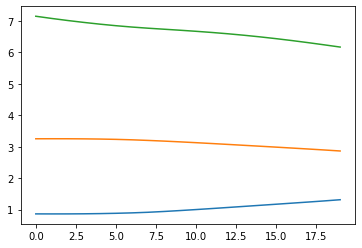

In [0]:
plt.plot([i for i in range(20)], means_x)
plt.plot([i for i in range(20)], means_y)
plt.plot([i for i in range(20)], means_z)
plt.show()

In [0]:
std_x = [scene[0][i][' x '].std() for i in range(20)]
std_y = [scene[0][i][' y '].std() for i in range(20)]
std_z = [scene[0][i][' z '].std() for i in range(20)]

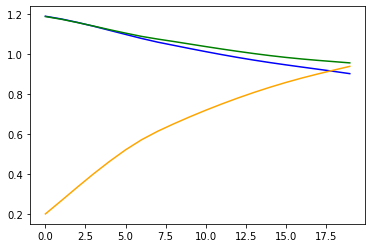

In [0]:
plt.plot([i for i in range(20)], std_x, color='blue')
plt.plot([i for i in range(20)], std_y, color='green')
plt.plot([i for i in range(20)], std_z, color='orange')
plt.show()

In [0]:
from mpl_toolkits.mplot3d import axes3d

def plot_frame(frame):
  z_x = [frame[j] for j in range(0,1200,3)]
  z_y = [frame[j] for j in range(1,1200,3)]
  z_z = [frame[j] for j in range(2,1200,3)]
  fig = plt.figure()
  fig.set_size_inches(18.5, 10.5)
  #ax = fig.add_subplot(1, 1, 1, axisbg="1.0")
  ax = fig.gca(projection='3d')
  ax.set_zlim3d(-5,5)
  ax.set_xlim3d(-5,5)
  ax.set_ylim3d(-5,5)
  ax.scatter(z_x,z_y,z_z)

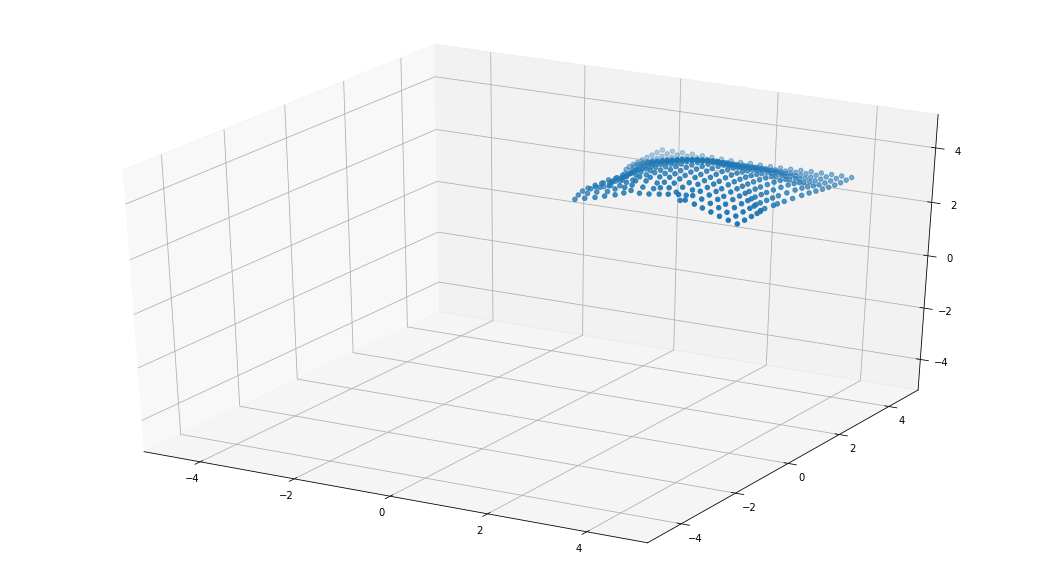

In [0]:
plot_frame(scenes[1][8])


# Data preperation

1.   We keep all the vertices for each frame in a single vector x(t) where t is the frame.
2.   We make a matrix X combining all the x(t) into a single matrix.



In [0]:
scenes[0][0].shape

(1200,)

In [0]:
allframes = []
for i in range(no_scenes):
  for t in range(20):
    allframes.append(scenes[i][t])


In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=32)
principalComponents = pca.fit_transform(allframes)

In [0]:
pca.components_.shape

(32, 1200)

In [0]:
len(principalComponents)

960

In [0]:
pca.inverse_transform(principalComponents[0])

array([1.03389303, 3.14941379, 4.96004669, ..., 3.41865266, 5.48412744,
       4.18575107])

In [0]:
len(allframes)

960

# Initial Model
We use linear regression to get the approximate motion of the cloth and to model inertia. 
This stage does not model the interaction with other objects.

In [0]:
from sklearn.linear_model import LinearRegression
import numpy as np

In [0]:
xk = []
for k in range(32):
  x1 = []
  for j in range(no_scenes):
    for i in range(18):
      x1.append([principalComponents[j*20 + i+1][k],principalComponents[j*20 + i+1][k]-principalComponents[j*20+i][k]])
  xk.append(x1)

In [0]:
yk = []
for k in range(32):
  y1 = []
  for j in range(no_scenes):
    for i in range(2,20):
      y1.append(principalComponents[j*20+i][k])
  yk.append(y1)

In [0]:
for i in range(32):
  xk[i] = np.array(xk[i])
  yk[i] = np.array(yk[i])

In [0]:
xk[0][1][0]

27.030284154002388

In [0]:
yk[0][0]

27.030284154002388

In [0]:
regressors = []
for k in range(32):
  regressors.append(LinearRegression().fit(xk[k],yk[k]))

In [0]:
len(principalComponents)

960

In [0]:
def predict_regressors(frame1transformed,frame2transformed):
  p1 = frame1transformed
  p2 = frame2transformed
  predictions = []
  for k in range(len(regressors)):
    z_pred = [p1[k],p2[k]]
    for i in range(1,17):
      #print(z_pred)
      z_pred.append(regressors[k].predict([[z_pred[i],z_pred[i]-z_pred[i-1]]])[0])
    predictions.append(z_pred)
  return predictions

In [0]:
def inverse_transform_predictions(z):
  predictions = []
  for f in range(18):
    z_new = []
    for i in range(32):
      z_new.append(z[i][f])
    predictions.append(pca.inverse_transform(z_new))
    #predictions.append(z_new)
  return predictions

In [0]:
z_pred = predict_regressors(principalComponents[40],principalComponents[41])

In [0]:
len(z_pred[1])

18

In [0]:
final_value = inverse_transform_predictions(z_pred)

In [0]:
len(final_value)

18

In [0]:
scenes[2][19]

array([-0.46815973,  3.78808178,  3.83237096, ...,  1.1925287 ,
        5.79302491,  3.29351231])

In [0]:
final_value[17]

array([-1.6597352 ,  3.58343333,  2.77158697, ...,  1.54572112,
        6.77218845,  2.75893335])

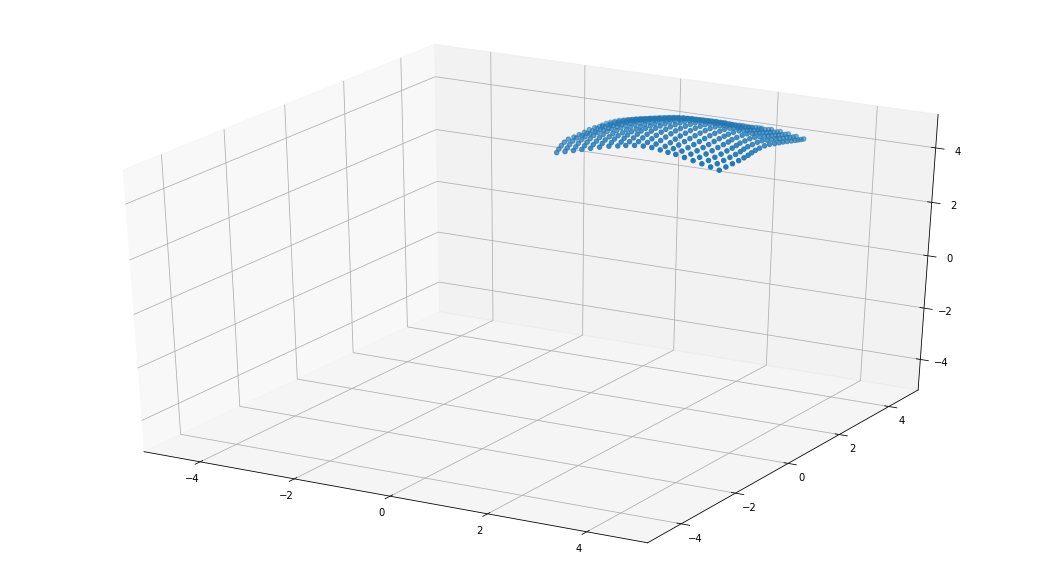

In [0]:
plot_frame(final_value[17])

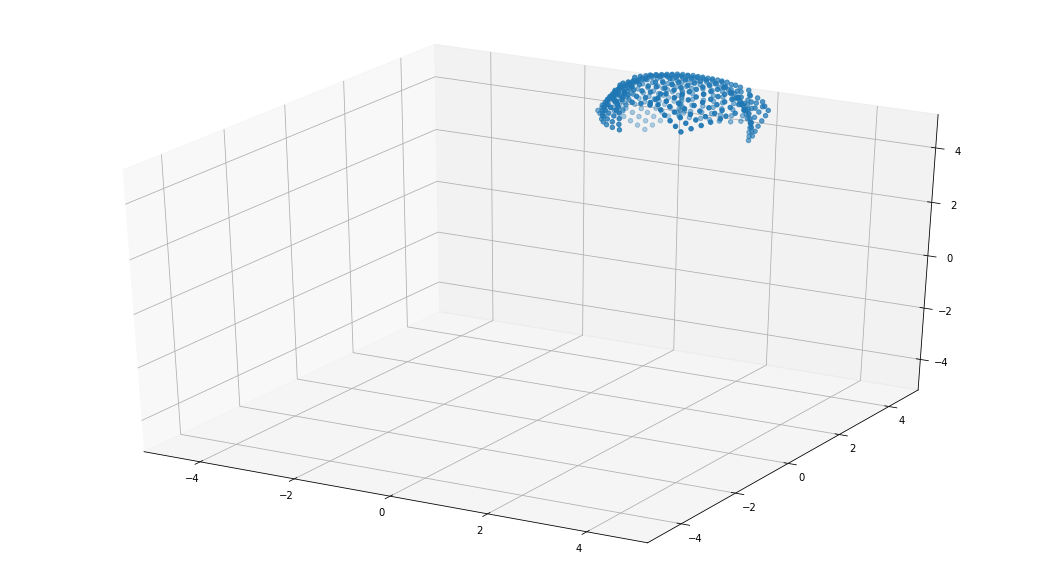

In [0]:
plot_frame(scenes[2][19])

# DNN correction 

In [0]:
x = scenes

In [0]:
y = np.array(df_y)

In [0]:
len(y)

48

In [0]:
len(x[0][0])

1200

In [0]:
for i in range(no_scenes):
  x[i] = pca.transform(x[i])

In [0]:
z_actual = []
for i in range(no_scenes):
  z_to_predict = []
  for j in range(2,20):
    z_to_predict.append(x[i][j])
  z_actual.append(z_to_predict)

In [0]:
def transform_predictions(z):
  predictions = []
  for f in range(18):
    z_new = []
    for i in range(32):
      z_new.append(z[i][f])
    #predictions.append(pca.inverse_transform(z_new))
    predictions.append(z_new)
  return predictions

In [0]:
z_pred = []
for i in range(no_scenes):
  z = predict_regressors(x[i][0],x[i][1])
  z_pred.append(transform_predictions(z))
  

In [0]:
z_pred[0][0]

[27.431111091207235,
 -20.825408663219843,
 -25.492973497193365,
 -6.2021798454103685,
 -4.591397158233352,
 8.38423056403094,
 -3.3500388473657052,
 -0.7494705081107522,
 1.1931778055020312,
 0.11912334465856433,
 -0.631203088659443,
 0.47109511041605723,
 0.6090790980978863,
 0.9626586453210371,
 0.4013171248921288,
 1.101416654962465,
 -0.26734699055685396,
 0.6943541989817675,
 -0.33022863892327126,
 -0.1383305973275557,
 0.35046740247942987,
 0.3090112788726718,
 0.03811481157989771,
 0.03177900280378876,
 0.18129301435162581,
 -0.33284509757558484,
 0.27779071029069724,
 0.14114714911959358,
 0.586652904918309,
 0.0654175750221615,
 -0.1389859987800936,
 -0.11189679341264147]

In [0]:
len(z_actual[0])

18

In [0]:
difference_vector = []
for i in range(no_scenes):
  difference = []
  for j in range(18):
    difference.append(z_actual[i][j] - z_pred[i][j])
  difference_vector.append(difference)



In [0]:
x = []
for i in range(no_scenes):
  for j in range(18):
    x.append(z_pred[i][j])

In [254]:
difference_vector[0][1]

array([-3.34352111e-01,  3.43430158e-01, -5.65310492e-01, -7.49111787e-01,
       -4.47765287e-01,  1.00885934e+00,  2.97307599e-01,  2.03568673e-01,
        1.57542961e-02,  5.22866322e-01,  3.18211467e-01, -1.74295740e-01,
       -1.92932796e-01, -7.76620418e-02, -1.17938614e-01,  4.54097787e-01,
        3.75571534e-02,  1.44189017e-01,  1.06092298e-01, -3.18959549e-02,
       -8.21183074e-02, -6.29811050e-02, -1.03326548e-01,  1.29264925e-04,
        8.99003435e-03,  6.99077838e-02, -1.08342868e-01,  2.10202529e-02,
       -1.30891778e-01, -5.83730572e-02, -2.83270392e-02, -1.94128209e-02])

In [0]:
def flatten_list(l):
  flat_list = []
  for sublist in l:
      for item in sublist:
          flat_list.append(item)
  return flat_list

In [0]:
z_pred_flat = flatten_list(z_pred)

In [0]:
difference_vector_flat = flatten_list(difference_vector)

In [0]:
difference_vector_flat = np.array(difference_vector_flat)

In [259]:
difference_vector_flat.shape

(864, 32)

In [0]:
x = []
for i in range(no_scenes):
  for j in range(18):
    x.append(np.hstack((z_pred_flat[i*18+j],y[i])))

In [0]:
x = np.array(x)

In [262]:
x.shape

(864, 38)

In [0]:
import keras.backend as kb
def cloth_loss(y_true,y_pred):
  l_pos = kb.mean(kb.square(y_true - y_pred))
  l_vel = kb.mean(kb.square([y_true[i+1]-y_true[i] - y_pred[i+1] + y_pred[i] for i in range(17)]))
  return l_pos+l_vel

In [0]:
from keras import Sequential
from keras.layers import Dense, Activation
import keras
opt = keras.optimizers.Adam(learning_rate=0.01,amsgrad='true')
dnn=Sequential()
dnn.add(Dense(int(x.shape[1]*1.5),input_dim=x.shape[1],activation='relu'))
dnn.add(Dense(int(x.shape[1]*1.5),activation='relu'))
dnn.add(Dense(difference_vector_flat.shape[1],activation='linear'))
dnn.compile(loss=cloth_loss,optimizer=opt,metrics=['accuracy'])

In [314]:
dnn.fit(x,difference_vector_flat,epochs=80,batch_size=18)

Epoch 1/80
864/864 [==============================] - 0s 316us/step - loss: 9.7446 - accuracy: 0.2454
Epoch 2/80
864/864 [==============================] - 0s 77us/step - loss: 6.3562 - accuracy: 0.5093
Epoch 3/80
864/864 [==============================] - 0s 77us/step - loss: 5.1894 - accuracy: 0.5671
Epoch 4/80
864/864 [==============================] - 0s 77us/step - loss: 4.5158 - accuracy: 0.5741
Epoch 5/80
864/864 [==============================] - 0s 78us/step - loss: 3.9714 - accuracy: 0.6181
Epoch 6/80
864/864 [==============================] - 0s 77us/step - loss: 3.5064 - accuracy: 0.6157
Epoch 7/80
864/864 [==============================] - 0s 77us/step - loss: 3.1342 - accuracy: 0.6470
Epoch 8/80
864/864 [==============================] - 0s 79us/step - loss: 2.8779 - accuracy: 0.6574
Epoch 9/80
864/864 [==============================] - 0s 82us/step - loss: 3.3940 - accuracy: 0.6285
Epoch 10/80
864/864 [==============================] - 0s 79us/step - loss: 3.0046 - accur

In [300]:
z_pred[2][1]

[15.189843966735996,
 -70.0078423826761,
 -36.162677202626746,
 -0.2609558398140601,
 -1.7265377967145819,
 -4.934344534765256,
 2.537111010615881,
 0.012696881000781701,
 -1.0179383812265197,
 -0.13624584416822372,
 -0.08745081102511648,
 0.23147182801820998,
 0.13592024616405496,
 -0.10378957767784858,
 -0.2526857765412114,
 0.03259287195555505,
 0.09107754691326386,
 0.1088380270919953,
 -0.12321027138080654,
 0.05130009627953225,
 0.15484395109846827,
 -0.07635752313718425,
 -0.01639710405803907,
 0.04191259793440194,
 -0.09591473302295017,
 0.04059514329887248,
 0.03732850366379725,
 0.05427634304915441,
 0.0010254883670394177,
 -0.04402156702211624,
 0.021600869374383852,
 0.00913239433271612]

In [0]:
d = dnn.predict(x)

In [316]:
d[1]

array([ 3.72688323e-01, -2.49905527e-01,  2.93606594e-02,  5.57112694e-03,
       -5.19169927e-01,  1.04635060e+00,  4.22797263e-01,  4.60634917e-01,
       -7.46489882e-01,  1.04694657e-01,  2.77938008e-01,  2.48847306e-01,
        2.20143527e-01, -1.37174666e-01, -8.31964165e-02, -1.13779090e-01,
       -9.27468315e-02,  2.19980553e-02, -3.48501019e-02, -1.01506665e-01,
       -1.22901328e-01, -1.80635974e-02,  1.03571266e-03, -5.84627967e-03,
        1.62936095e-02,  1.12040535e-01, -2.18315050e-04, -3.17632705e-02,
       -1.69762038e-02,  6.42931610e-02,  2.82586142e-02,  2.74574328e-02],
      dtype=float32)

In [317]:
z_pred_flat[1]

[27.20747640754515,
 -20.671373063603657,
 -25.72805150623239,
 -6.565937545498038,
 -4.857970441646522,
 8.992283966556805,
 -3.228267103229073,
 -0.6730743131772163,
 1.1996289061254353,
 0.3772202244972124,
 -0.5019690571010792,
 0.41548734854197766,
 0.4911115919823179,
 0.887950075806294,
 0.36204465511531003,
 1.3263776061076267,
 -0.2672116063909016,
 0.8148089041967437,
 -0.2911309067768244,
 -0.17826997489983176,
 0.30752628962961026,
 0.28760998345150357,
 -0.007535570023529337,
 0.0524891453661509,
 0.19146967045091257,
 -0.30869435607741635,
 0.23581305592597857,
 0.1698745987476714,
 0.5407643642933639,
 0.01136489897359394,
 -0.14645061029919723,
 -0.10379539778675734]

In [0]:
correct_op = np.array(z_pred_flat[36]) + d[36]

In [0]:
final_vertices = pca.inverse_transform(correct_op)

In [0]:
def plot_sphere_frame(frame,yd):
  z_x = [frame[j] for j in range(0,1200,3)]
  z_y = [frame[j] for j in range(1,1200,3)]
  z_z = [frame[j] for j in range(2,1200,3)]
  fig = plt.figure()
  fig.set_size_inches(10.5, 10.5)
  #ax = fig.add_subplot(1, 1, 1, axisbg="1.0")
  ax = fig.gca(projection='3d')
  u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
  x = yd[0]+np.cos(u)*np.sin(v)*yd[3]/2
  y = yd[1]+np.sin(u)*np.sin(v)*yd[4]/2
  z = yd[2]+np.cos(v)*yd[5]/2
  ax.plot_wireframe(x, y, z, color="r")
  ax.set_zlim3d(-5,5)
  ax.set_xlim3d(-5,5)
  ax.set_ylim3d(-5,5)
  ax.scatter(z_x,z_y,z_z)

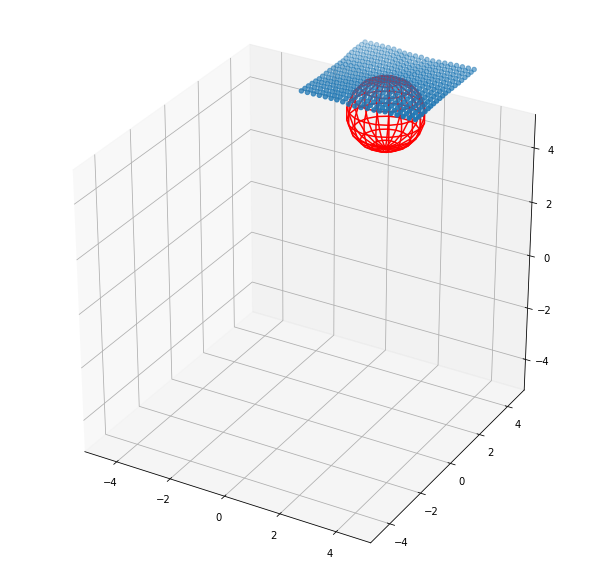

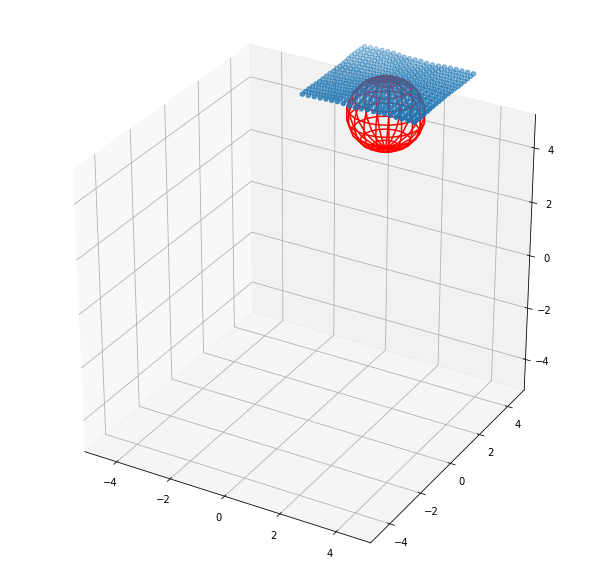

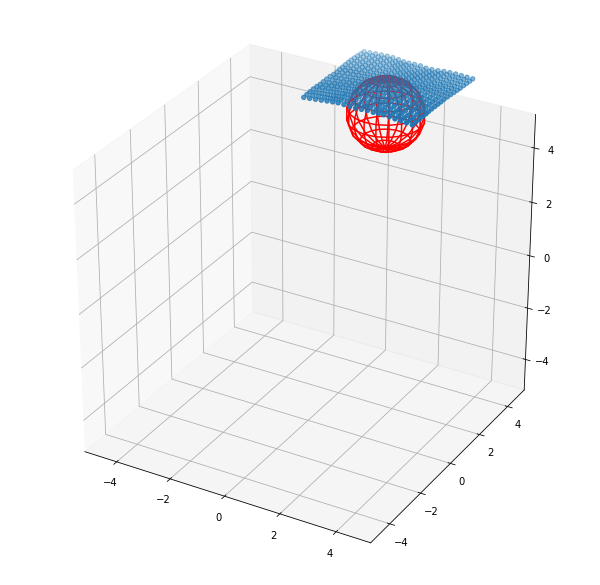

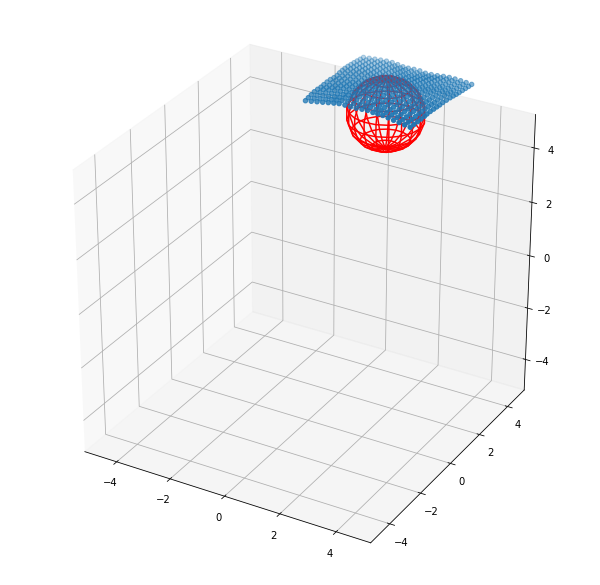

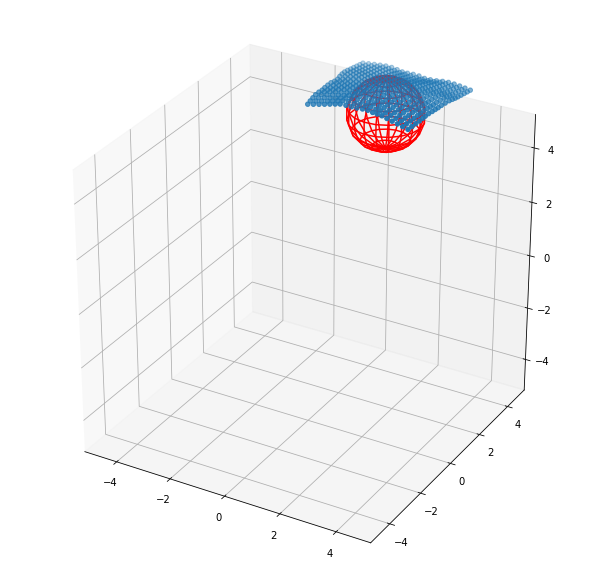

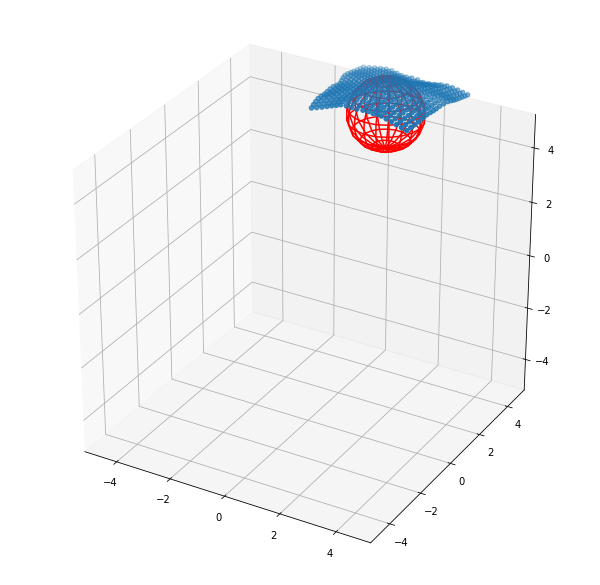

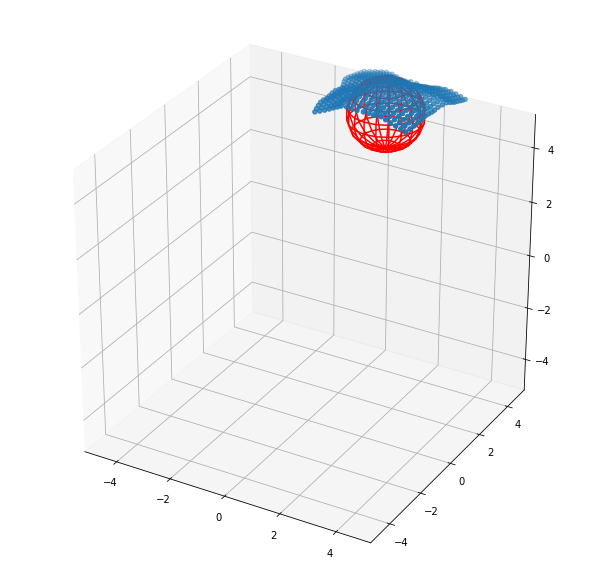

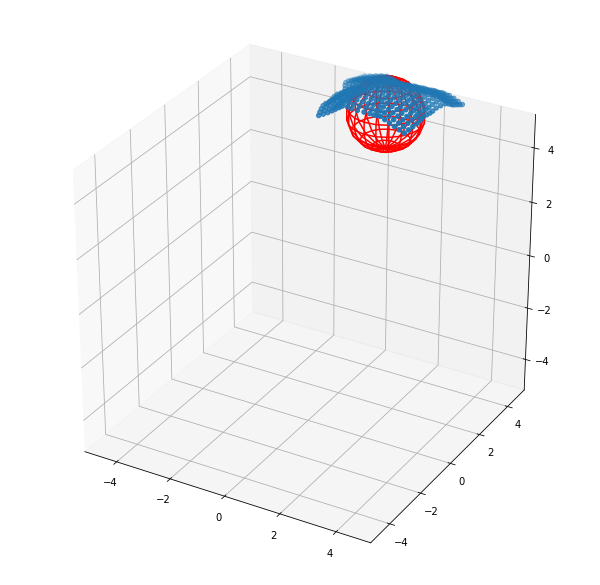

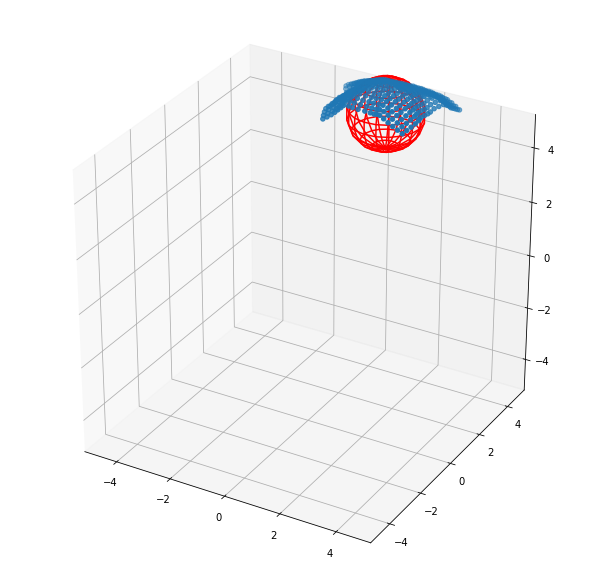

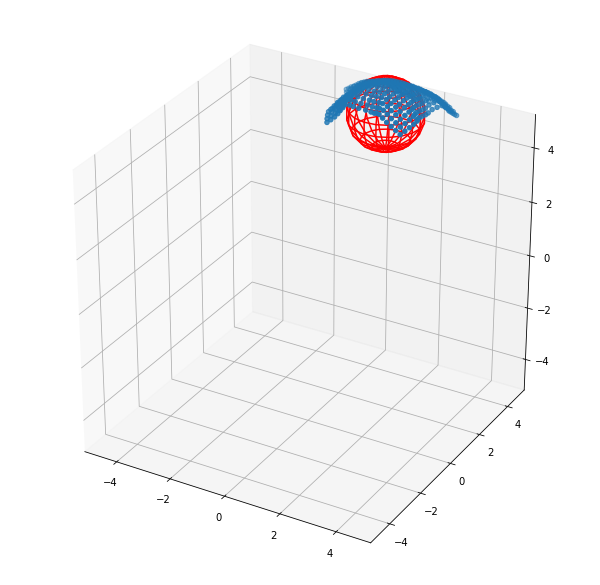

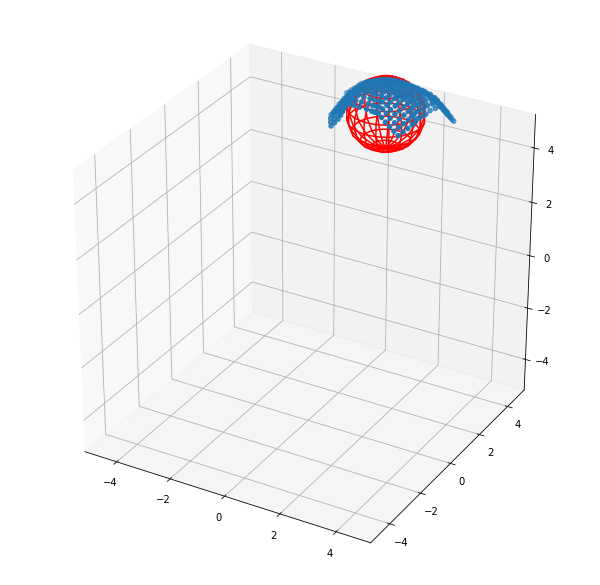

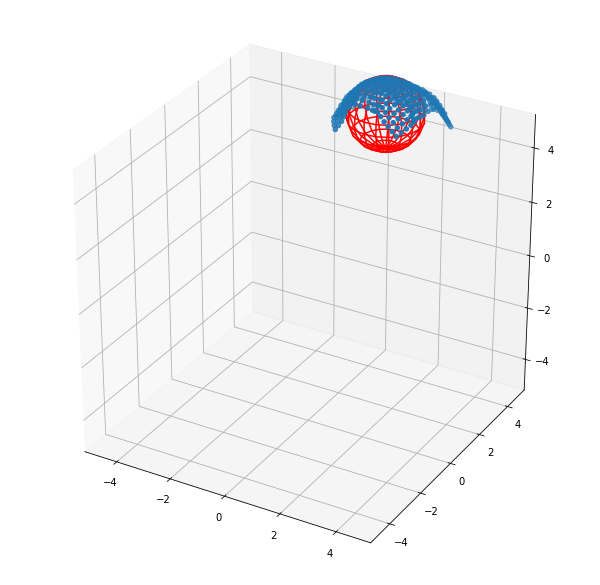

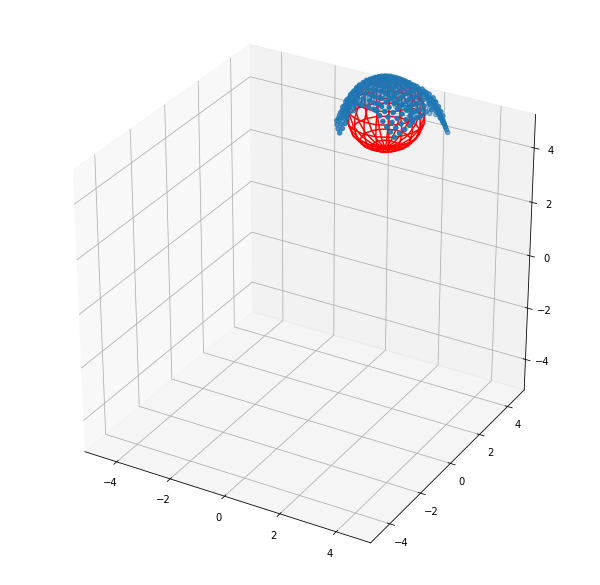

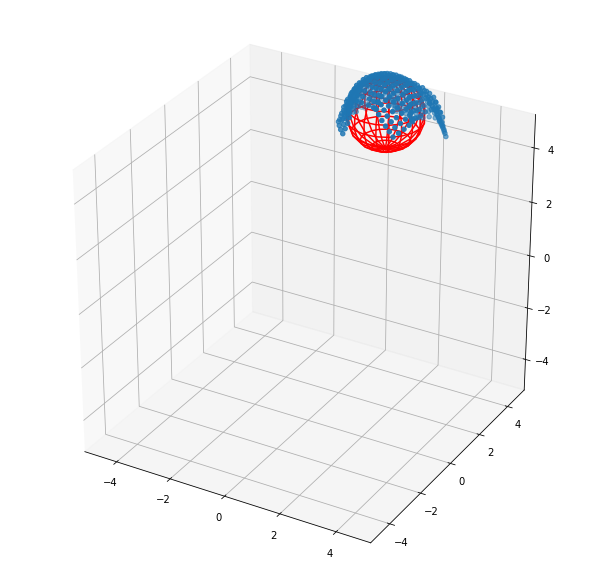

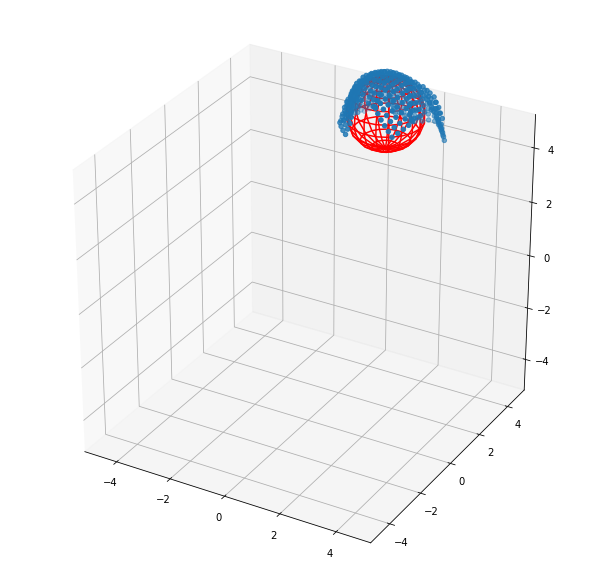

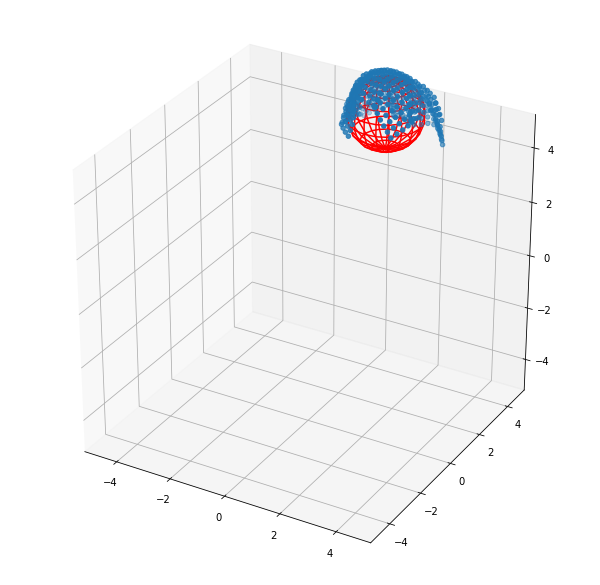

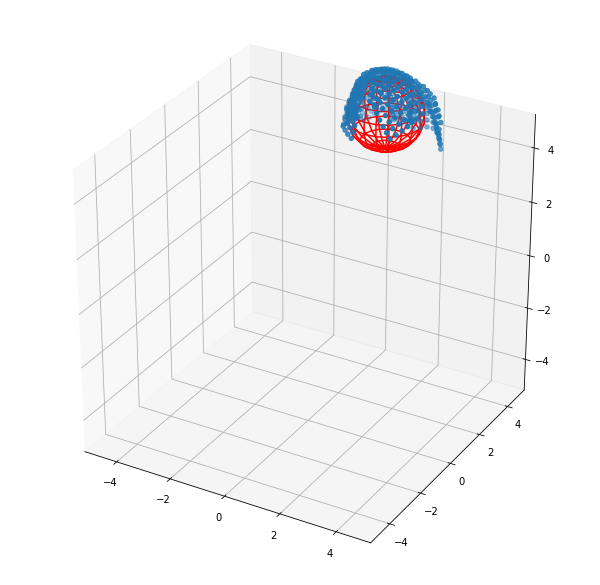

In [346]:
for i in range(17):
  correct_op = np.array(z_pred_flat[36+i]) + d[36+i]
  final_vertices = pca.inverse_transform(correct_op)
  plot_sphere_frame(final_vertices,y[2])

In [339]:
y[2]

array([0.        , 5.        , 4.        , 2.55031109, 2.55031157,
       2.55031109])

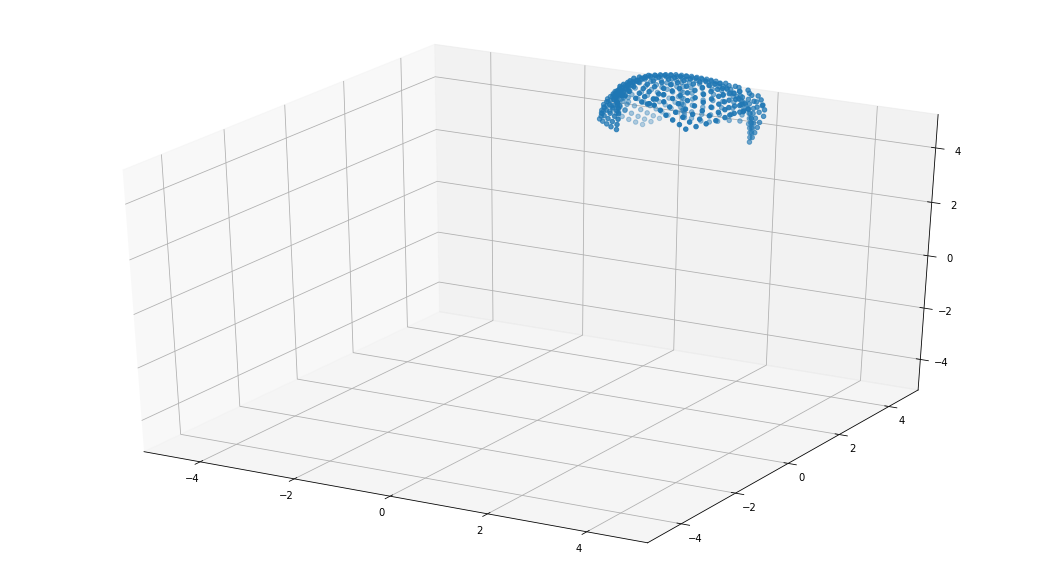

In [308]:
plot_frame(pca.inverse_transform(scenes[2][19]))

In [0]:
dnn.save("model.h5")

In [0]:
import pickle

In [0]:
regressionModels = open("lrmodels.csv", "w+")

In [205]:
regressionModels.write("coef1,coef2,intercept1\n")

23

In [0]:
for r in regressors:
  regressionModels.write(str(r.coef_[0])+","+str(r.coef_[1])+","+str(r.intercept_))
  regressionModels.write("\n")


In [207]:
regressors[0].intercept_

0.0015835560148635963

In [0]:
regressionModels.close()

In [0]:
import pickle as pk

In [0]:
pk.dump(pca, open("pca.pkl","wb"))

In [0]:
test_data_x = pd.read_csv('/content/drive/My Drive/MLProjectDataset/test_data_x.csv')
test_data_y = pd.read_csv('/content/drive/My Drive/MLProjectDataset/test_data_y.csv')

In [0]:
test_x = prepare_data(test_data_x,1,400,20)

In [0]:
pca_compressions = pca.transform(test_x[0])

In [0]:
zi_test = predict_regressors(pca_compressions[0],pca_compressions[1])

In [0]:
zi_preds = transform_predictions(zi_test)

In [226]:
len(zi_preds[0])

32

In [0]:
test_y = np.array(test_data_y)

In [0]:
x_test = []
for j in range(18):
    x_test.append(np.hstack((zi_preds[j],test_y[0])))

In [0]:
x_test = np.array(x)

In [248]:
x_test.shape

(18, 38)

In [0]:
corrections = dnn.predict(x_test)

In [0]:
output = np.array(zi_preds) + corrections

In [0]:
final_vertices = pca.inverse_transform(output)

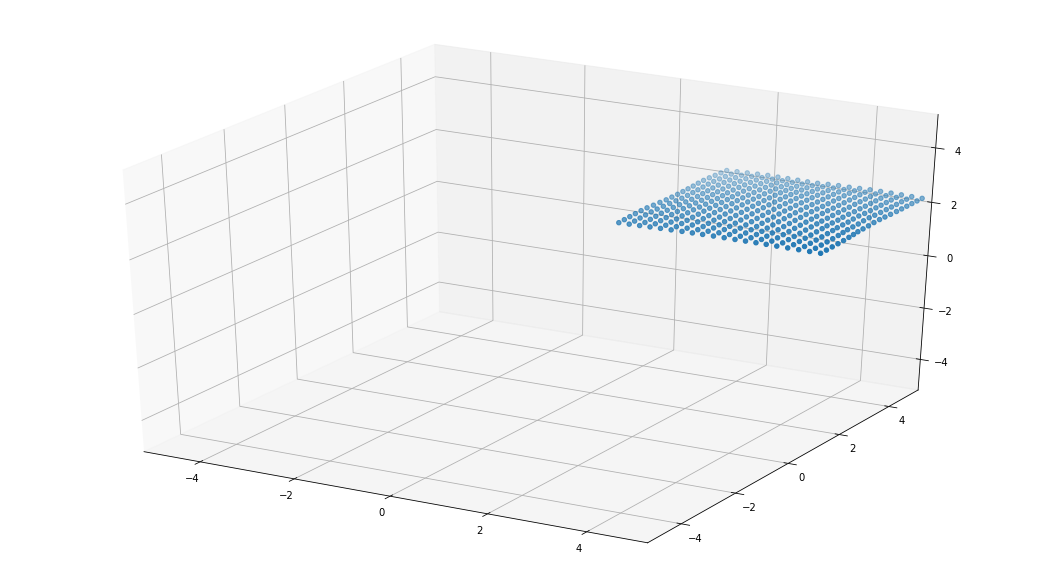

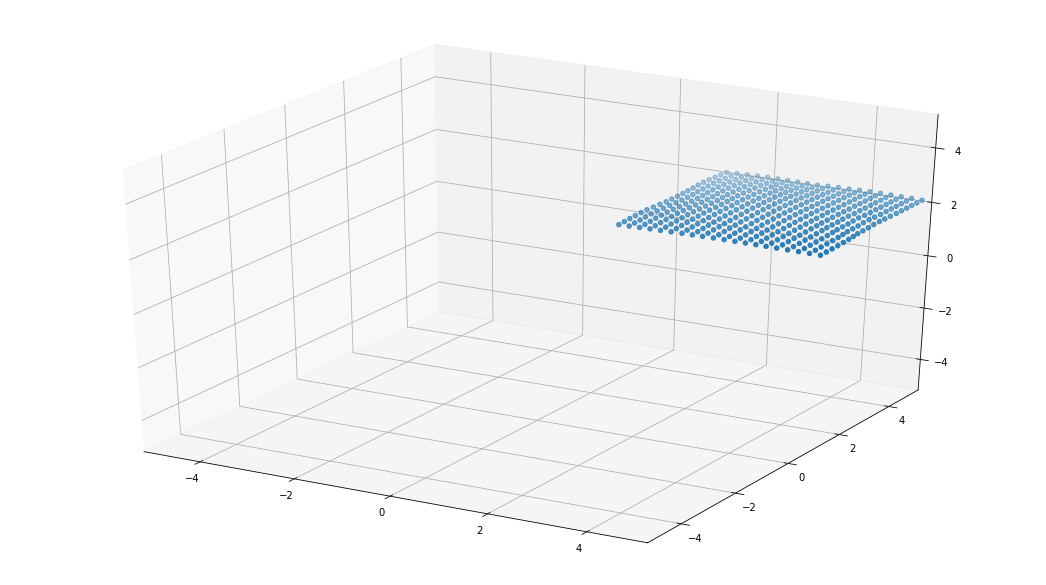

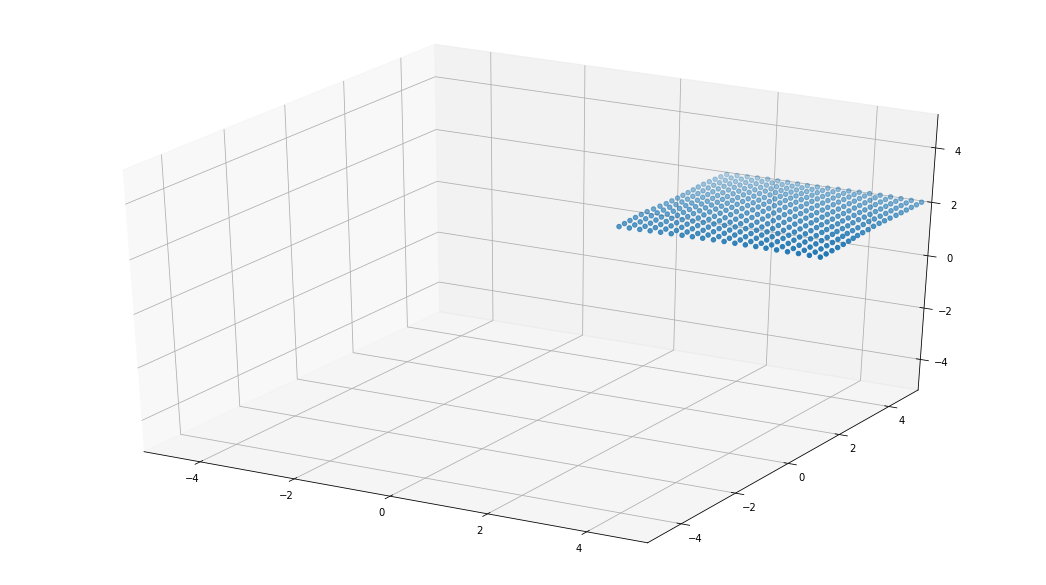

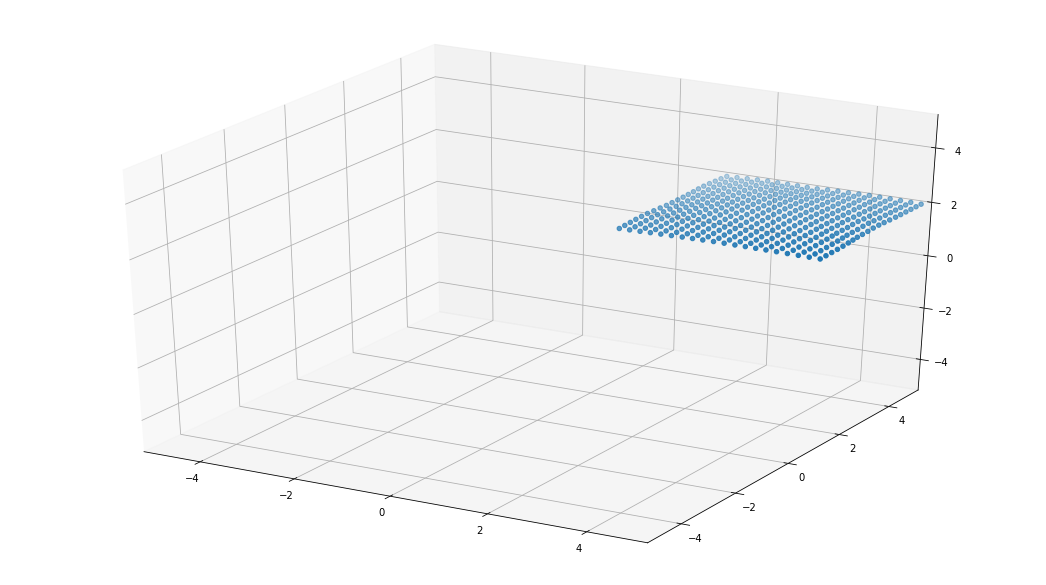

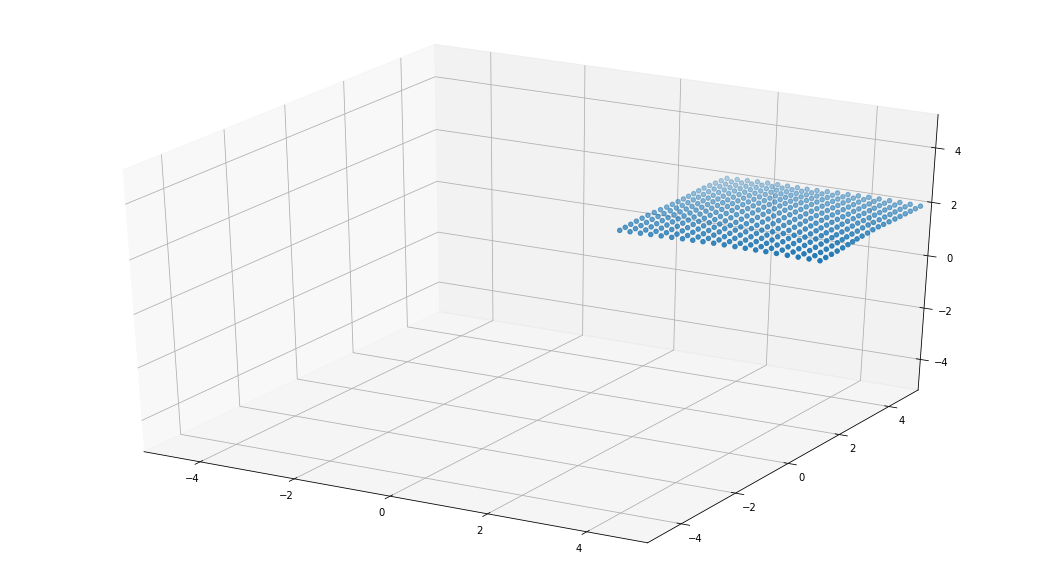

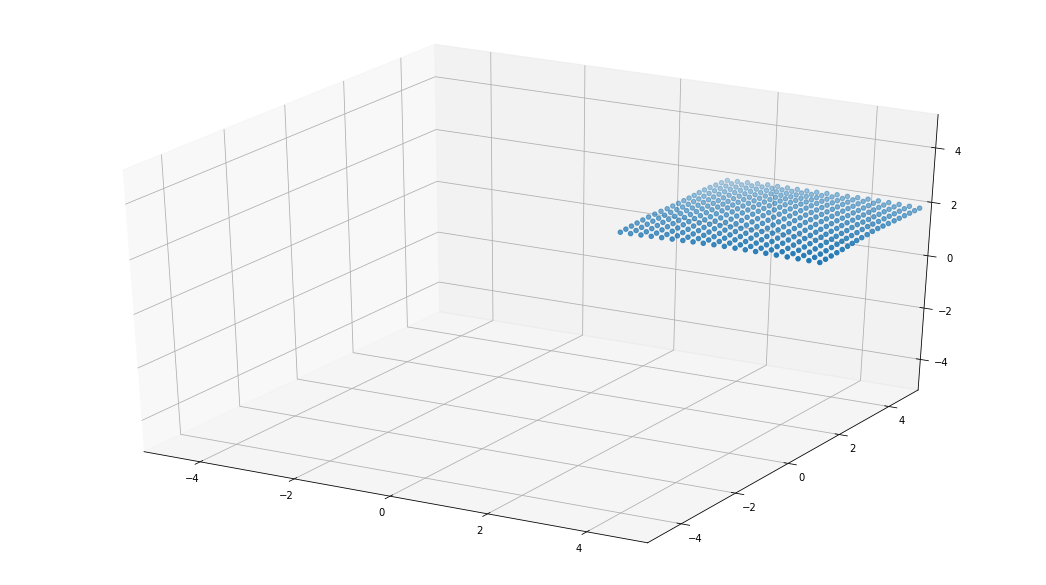

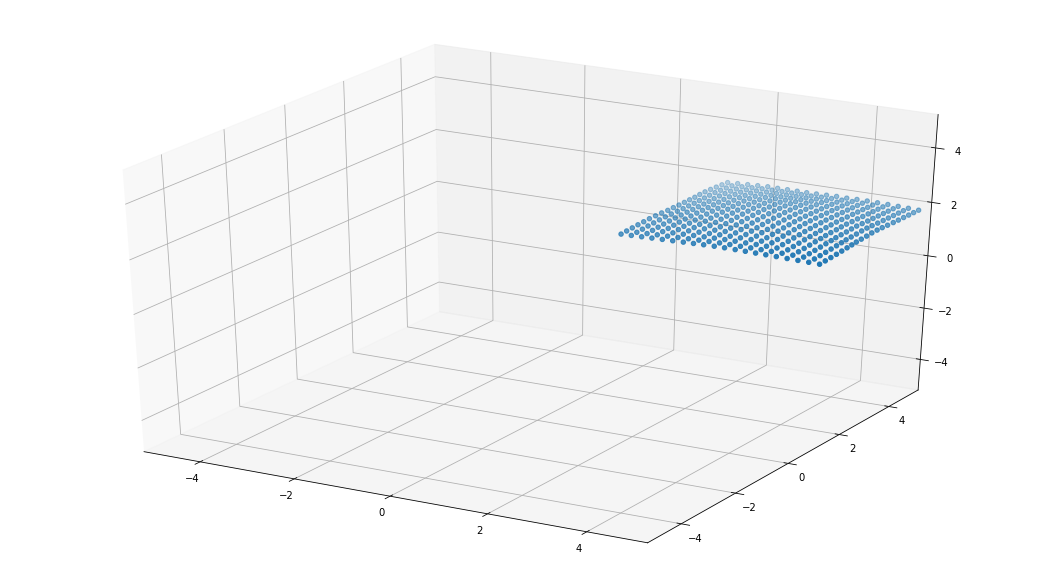

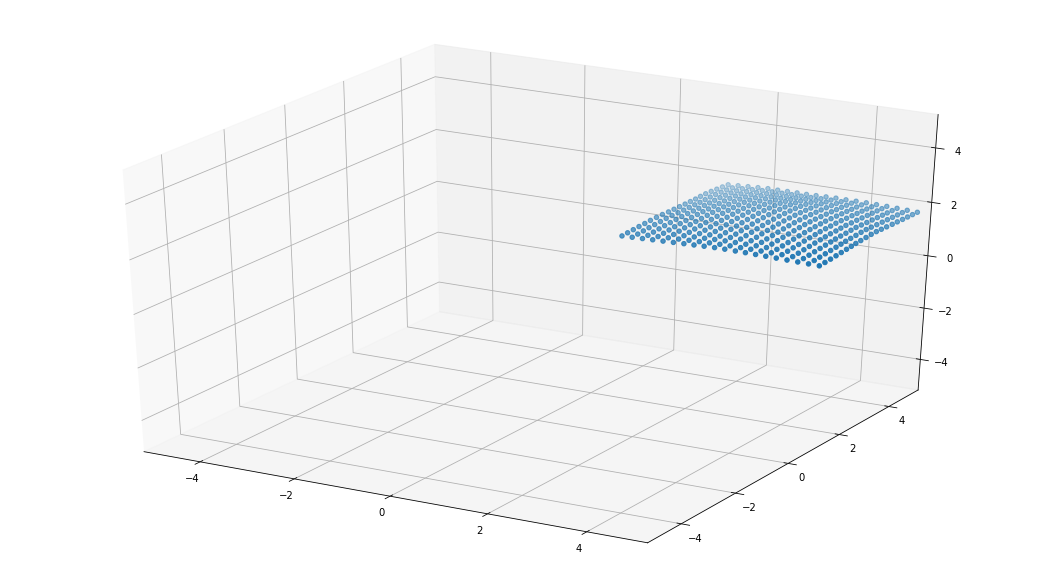

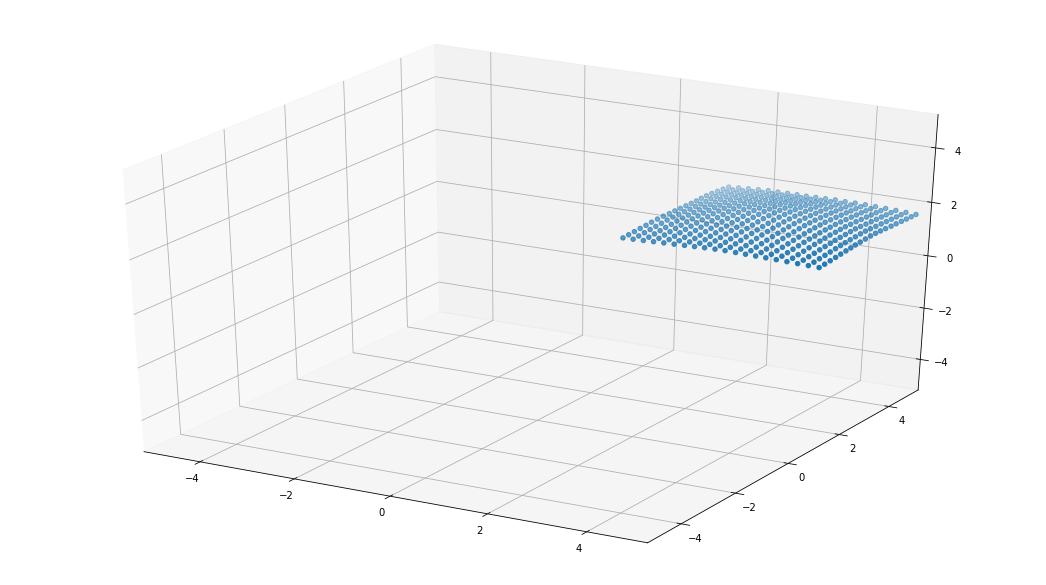

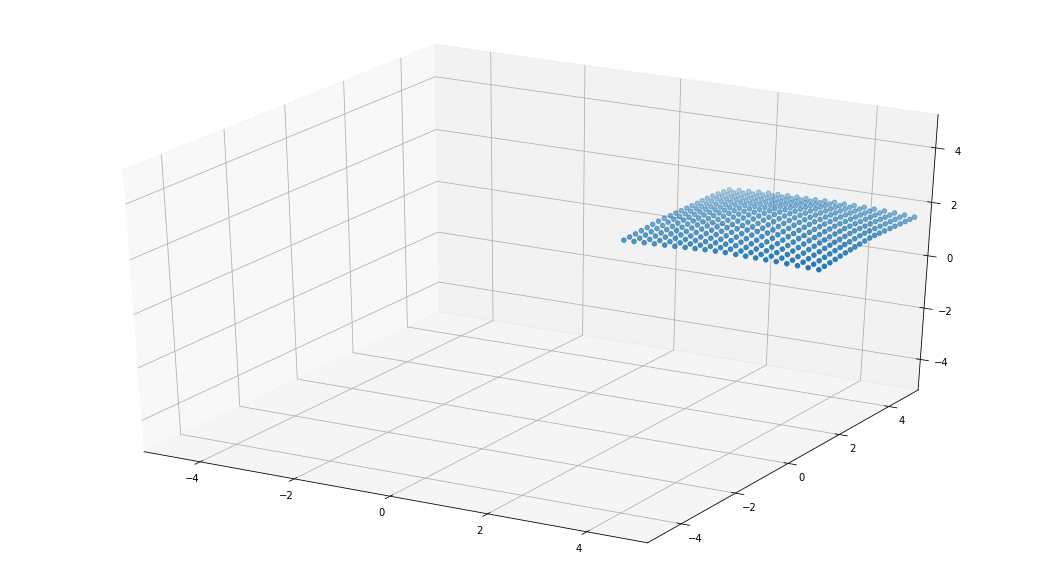

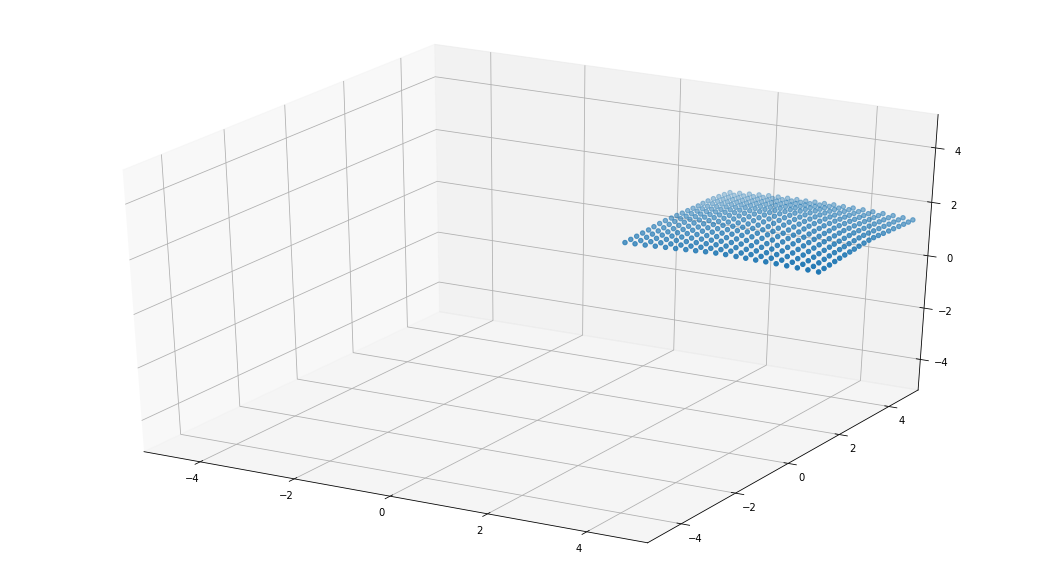

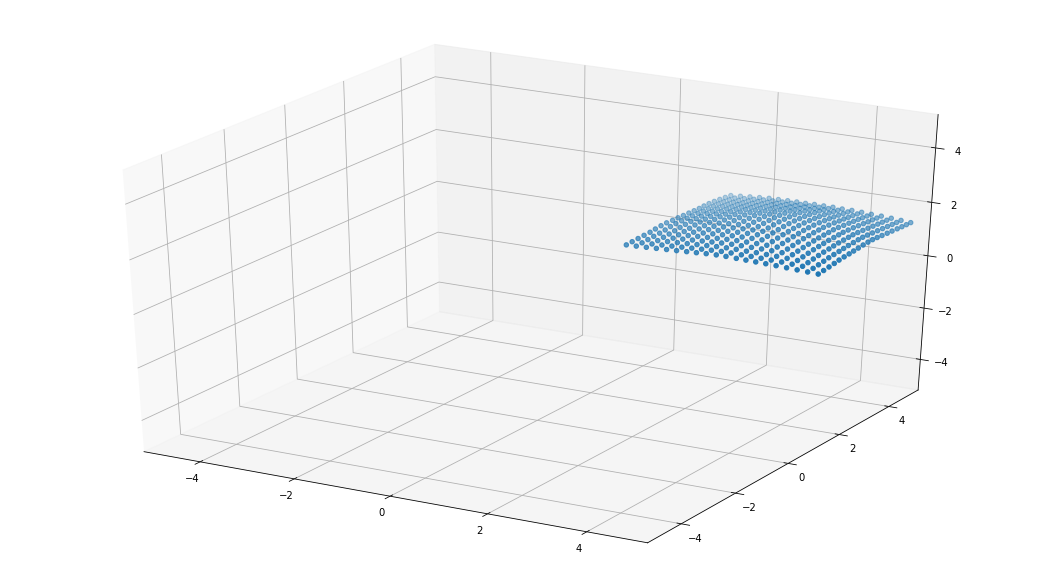

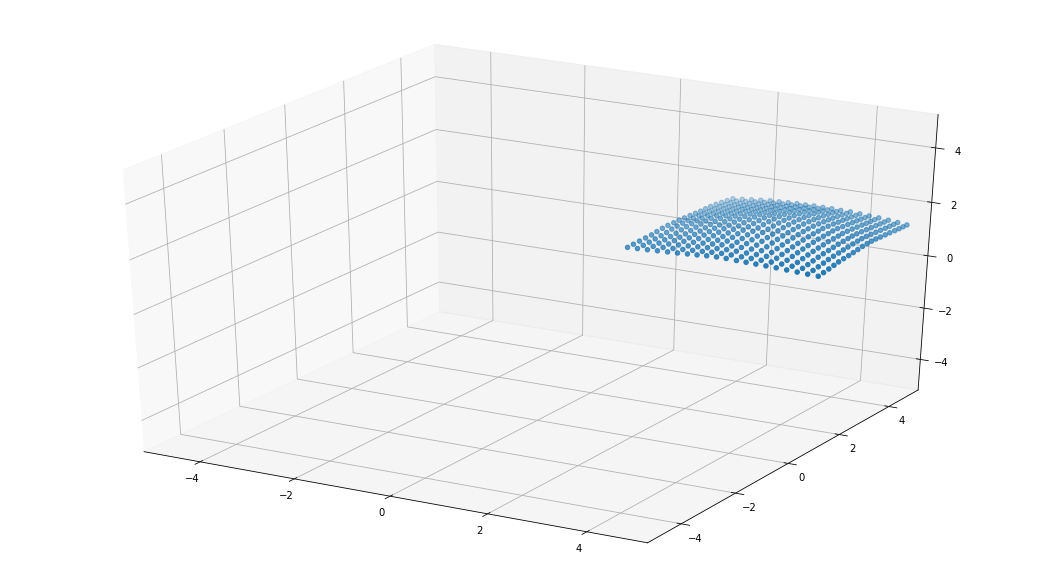

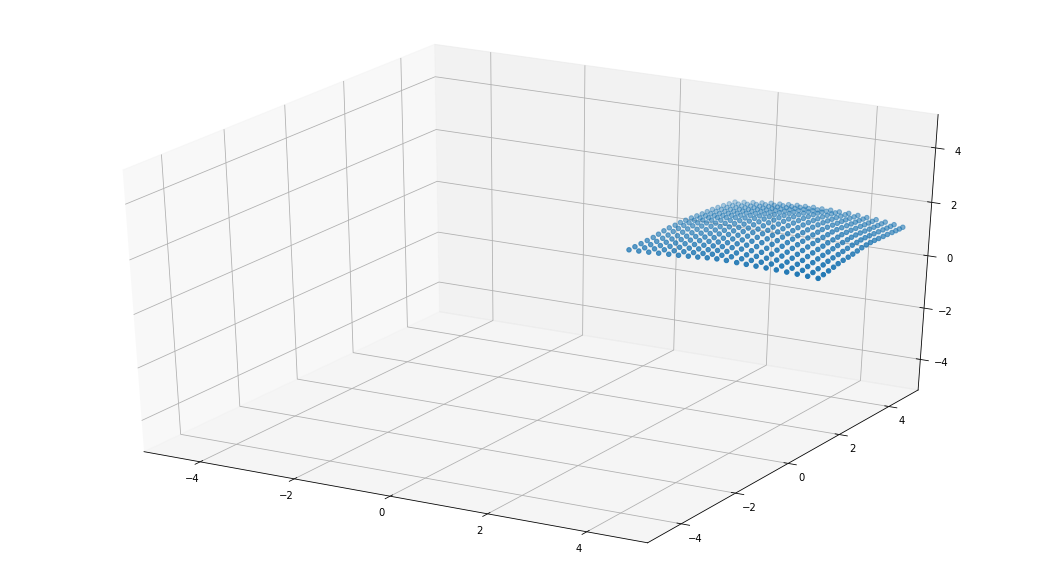

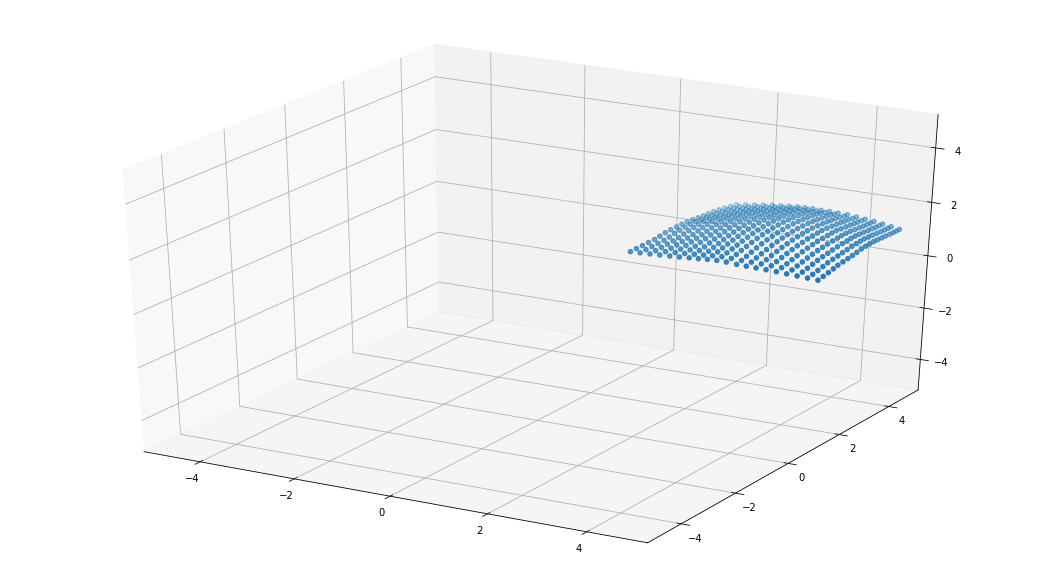

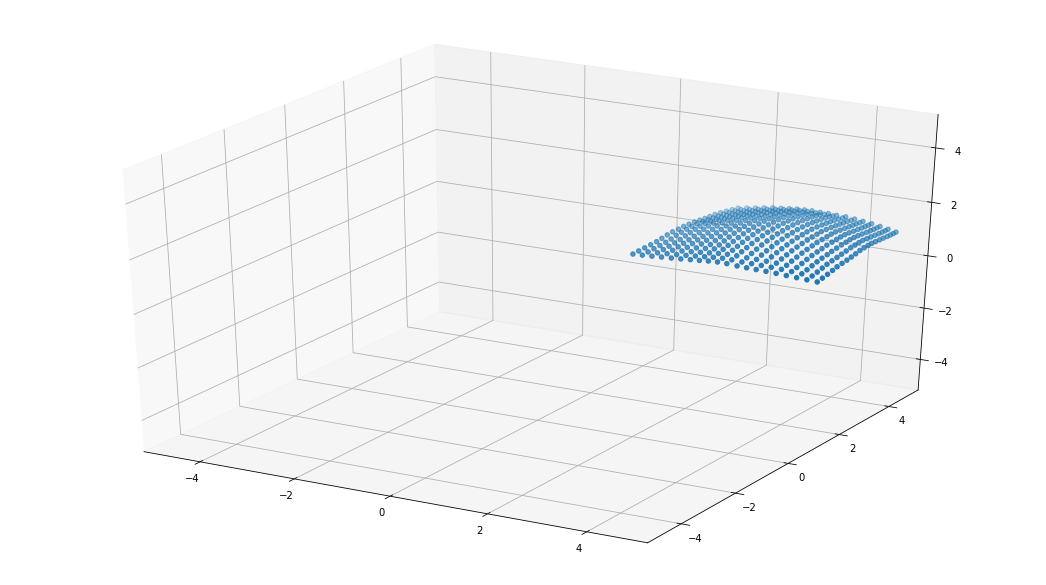

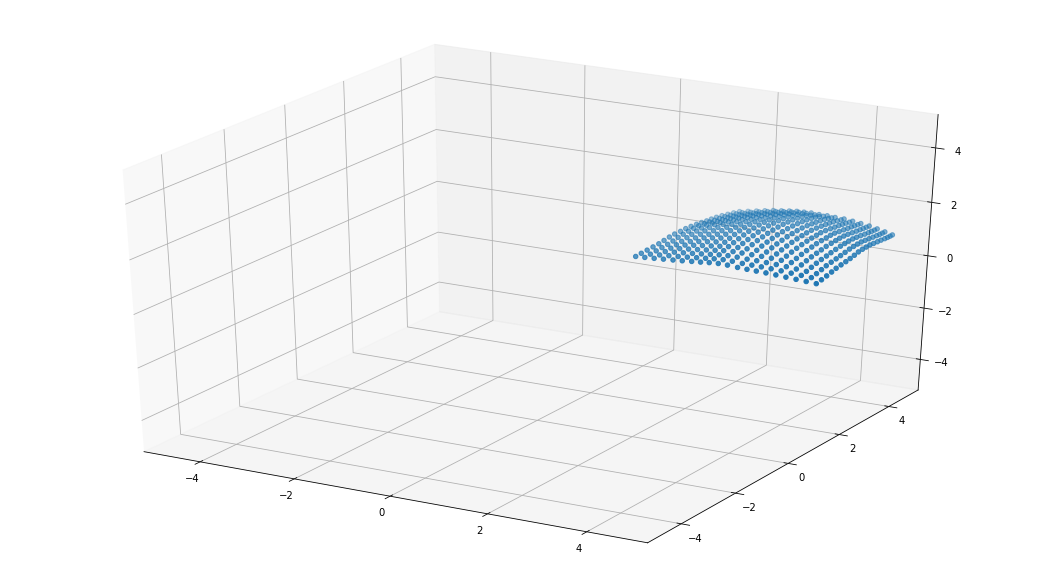

In [324]:
for i in range(17):
  plot_frame(final_vertices[i])

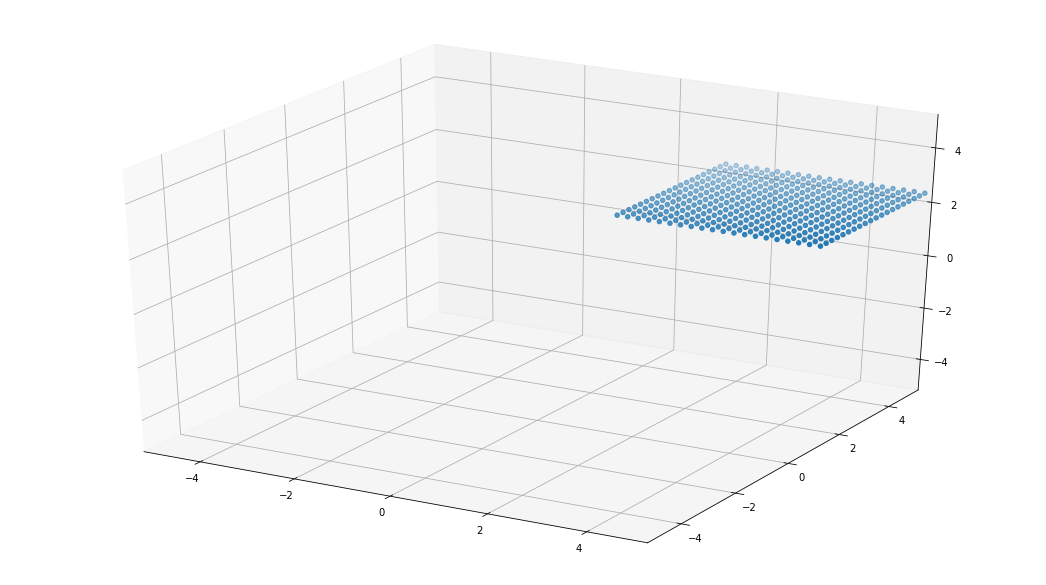

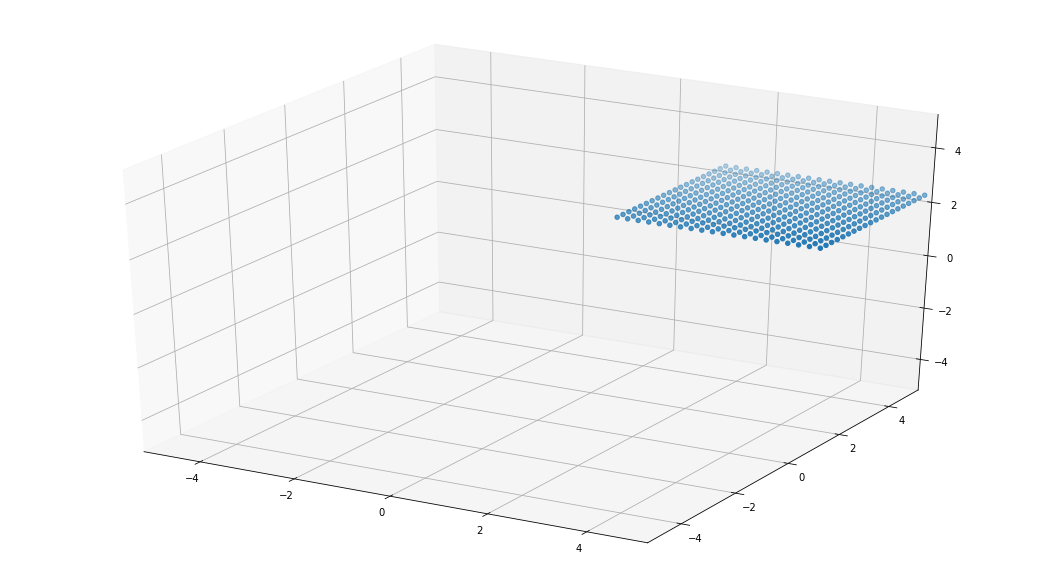

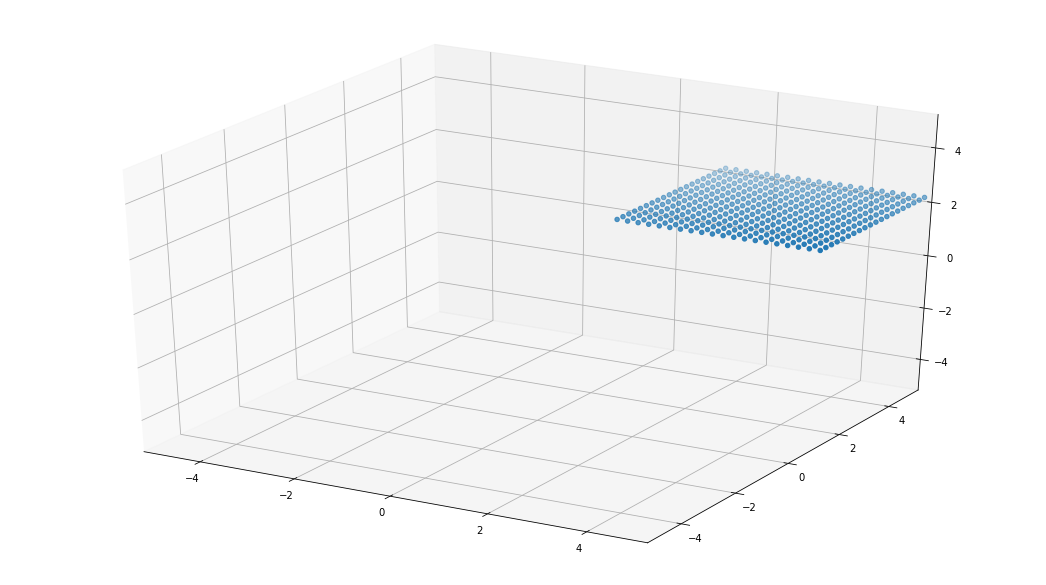

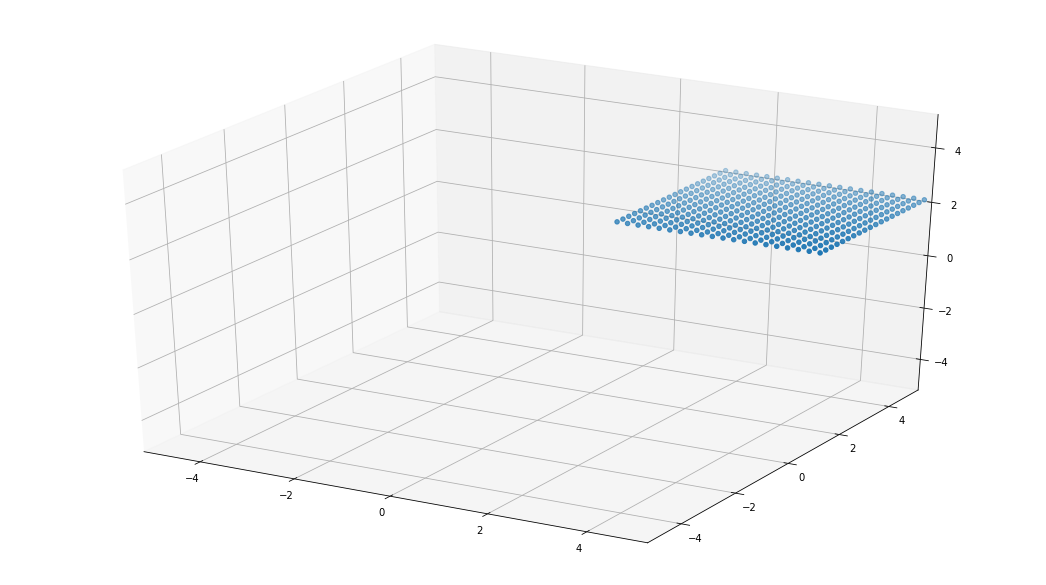

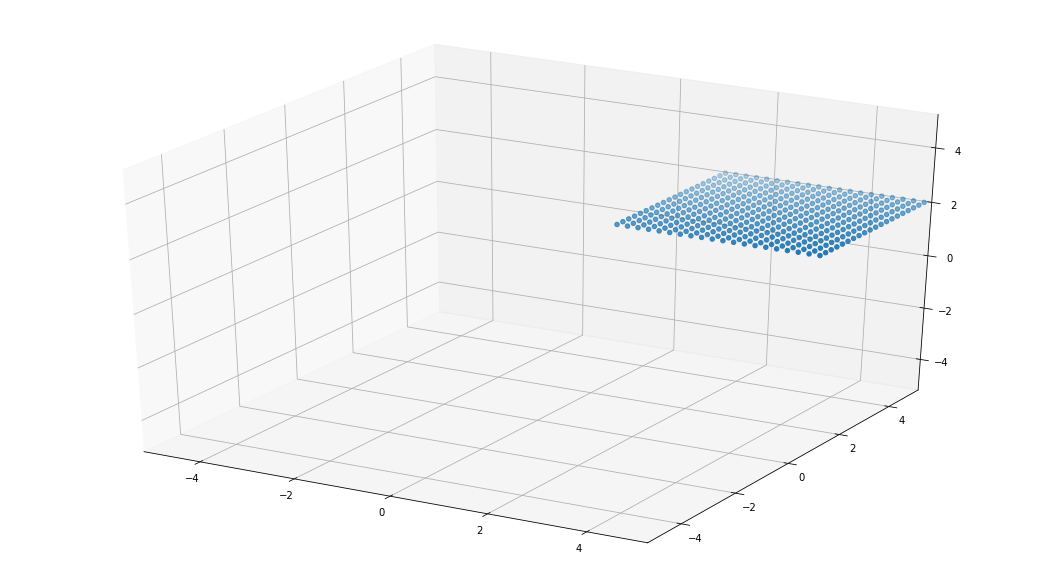

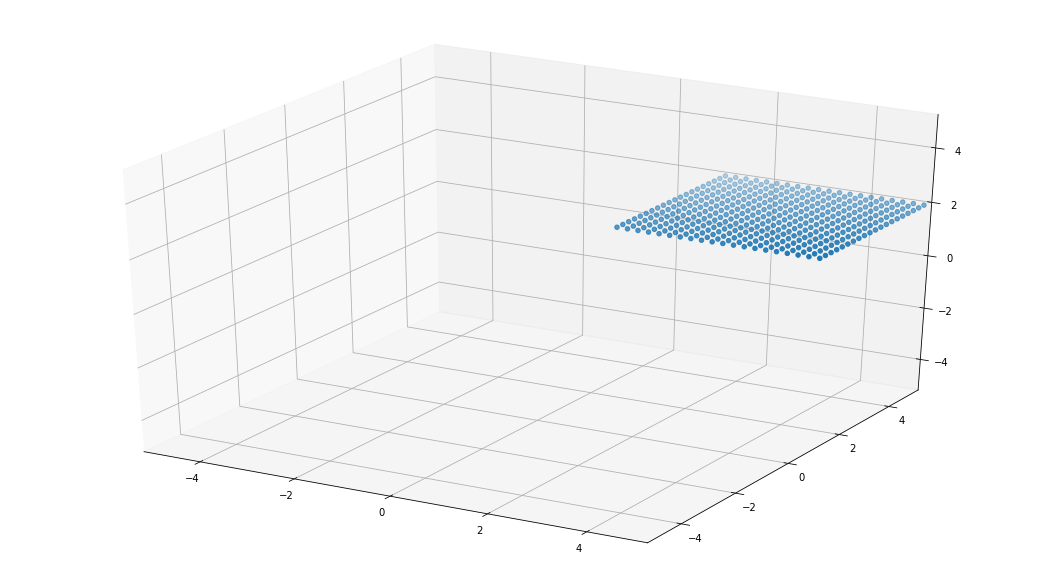

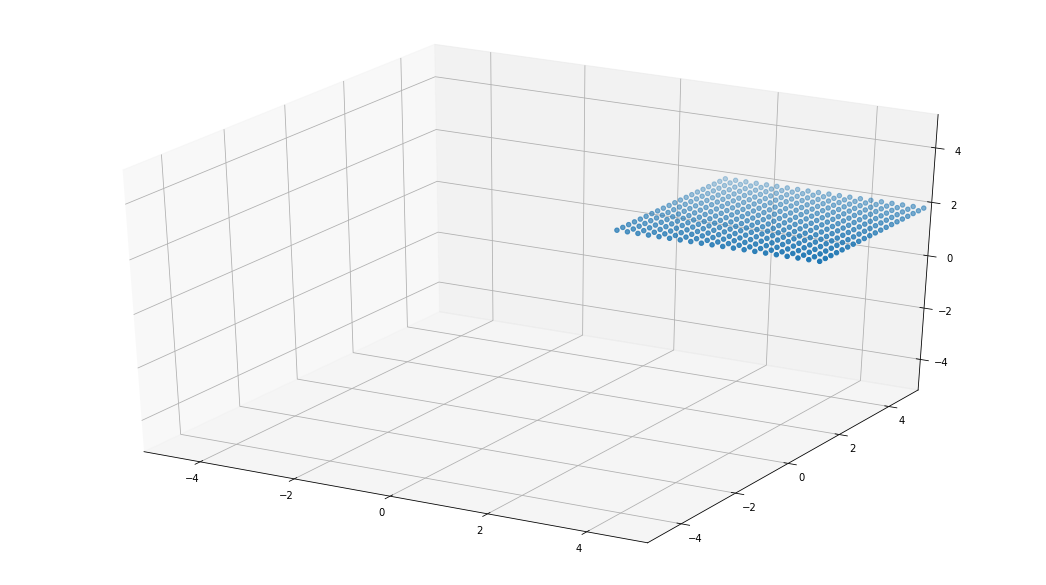

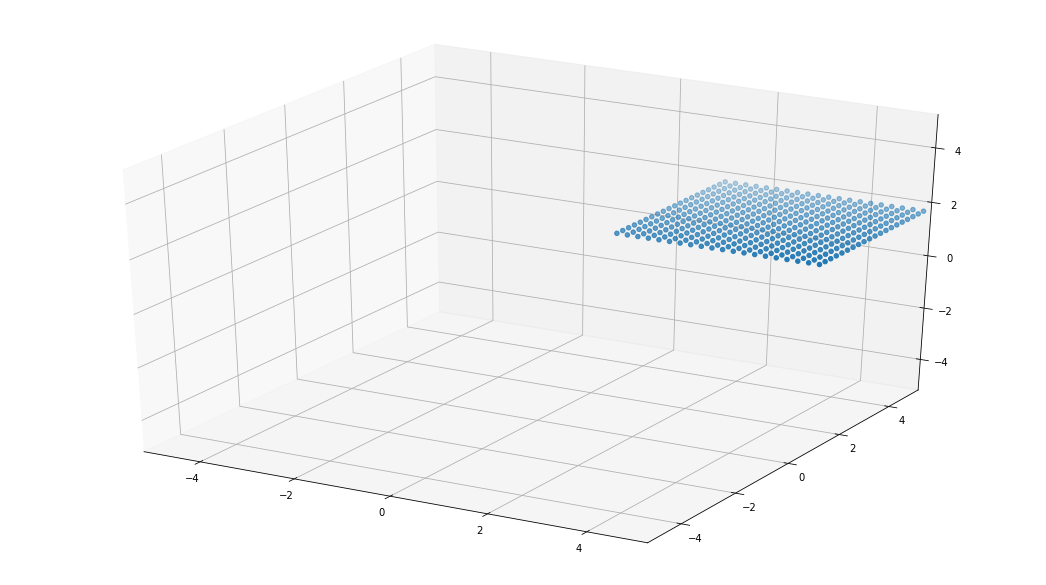

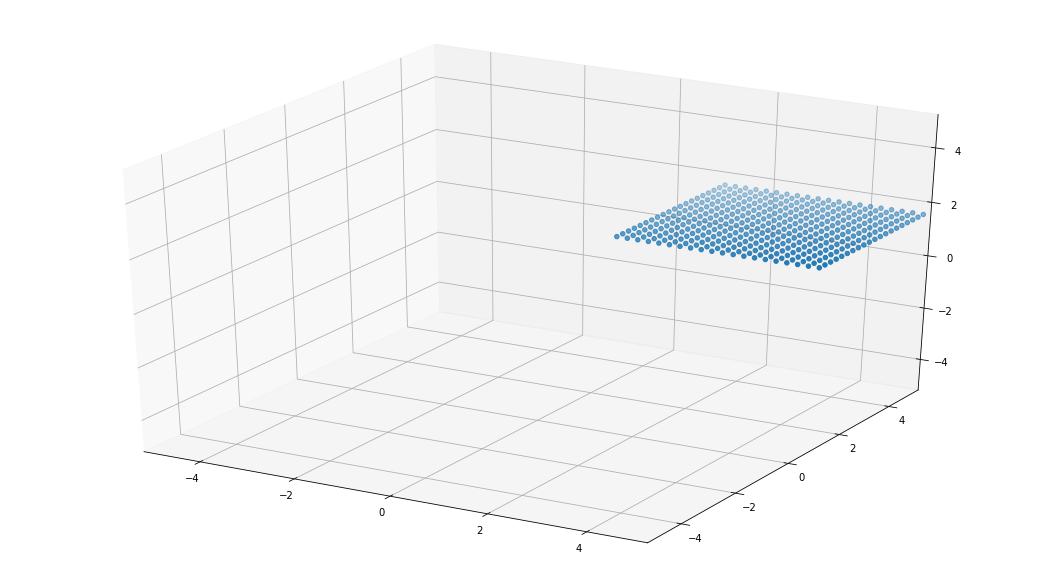

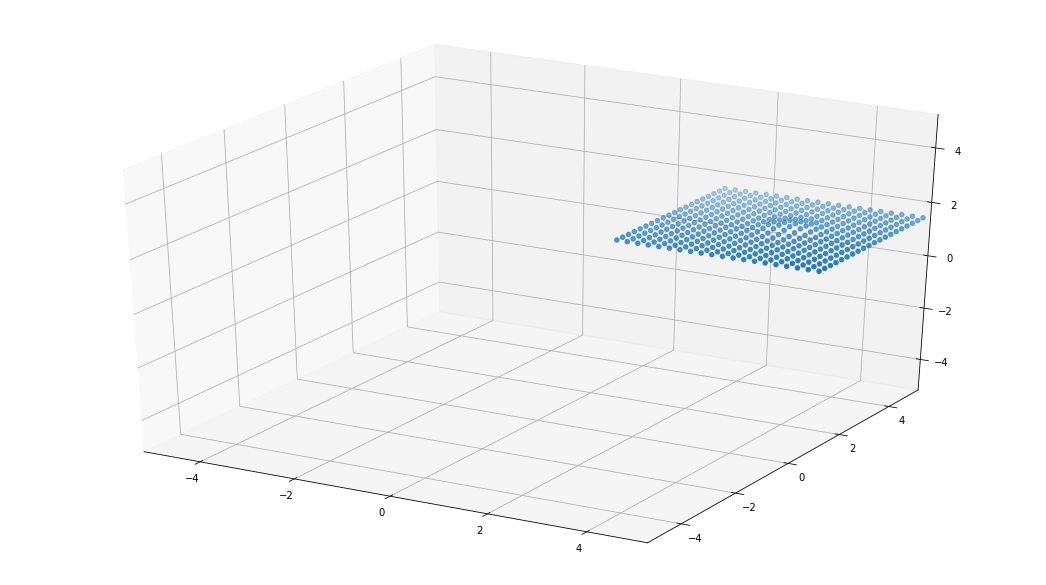

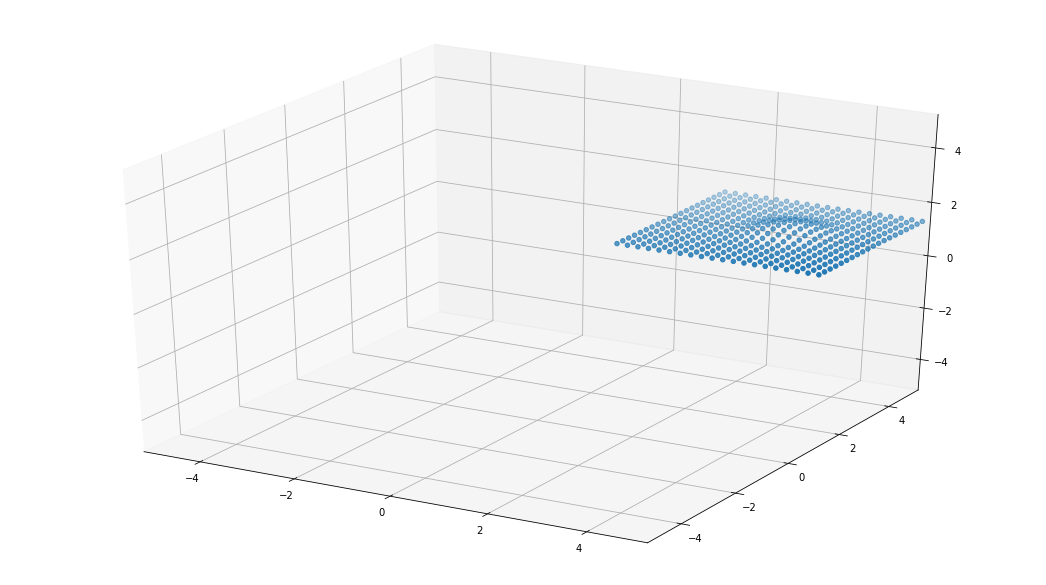

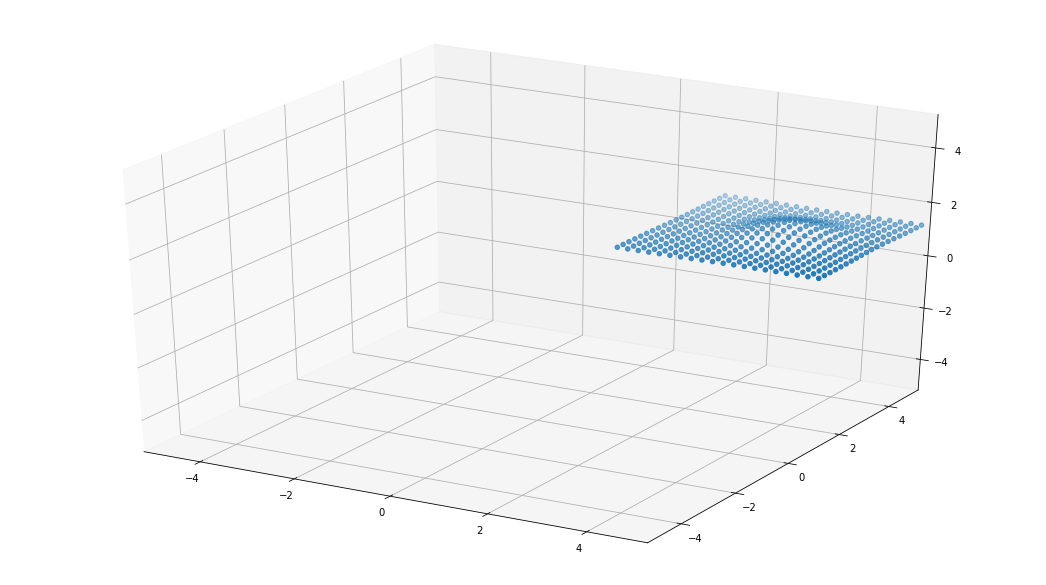

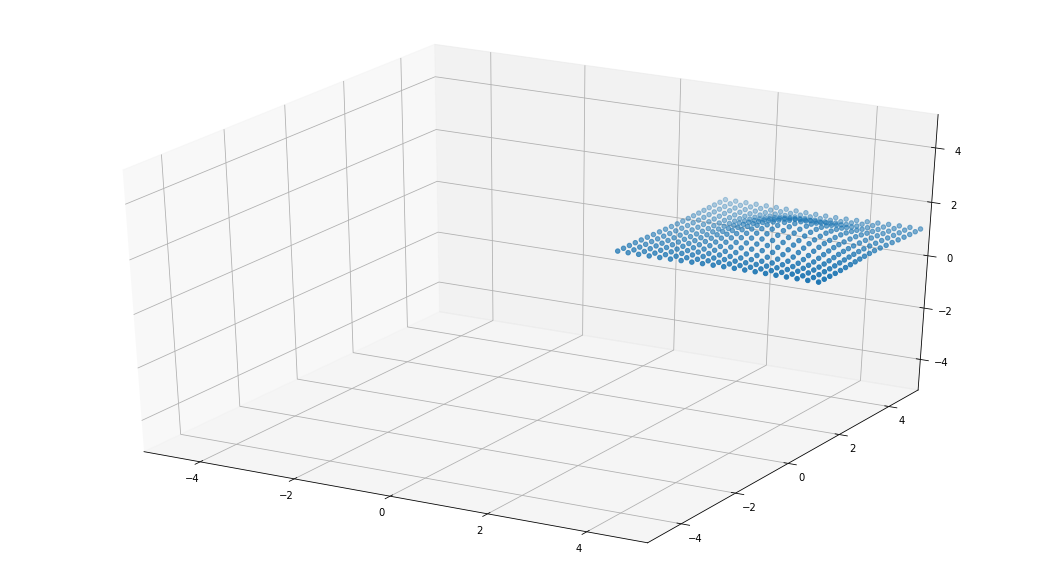

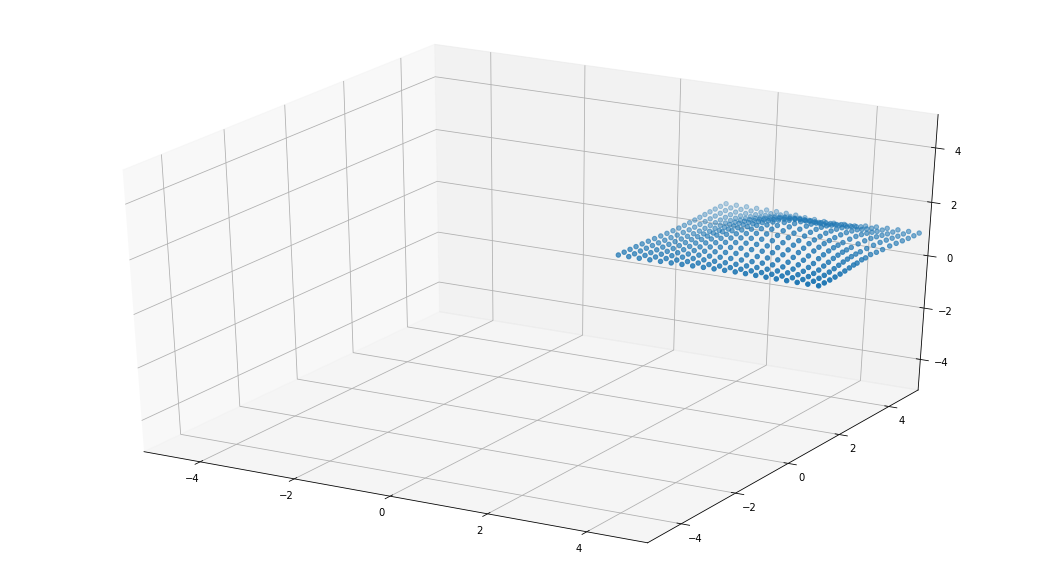

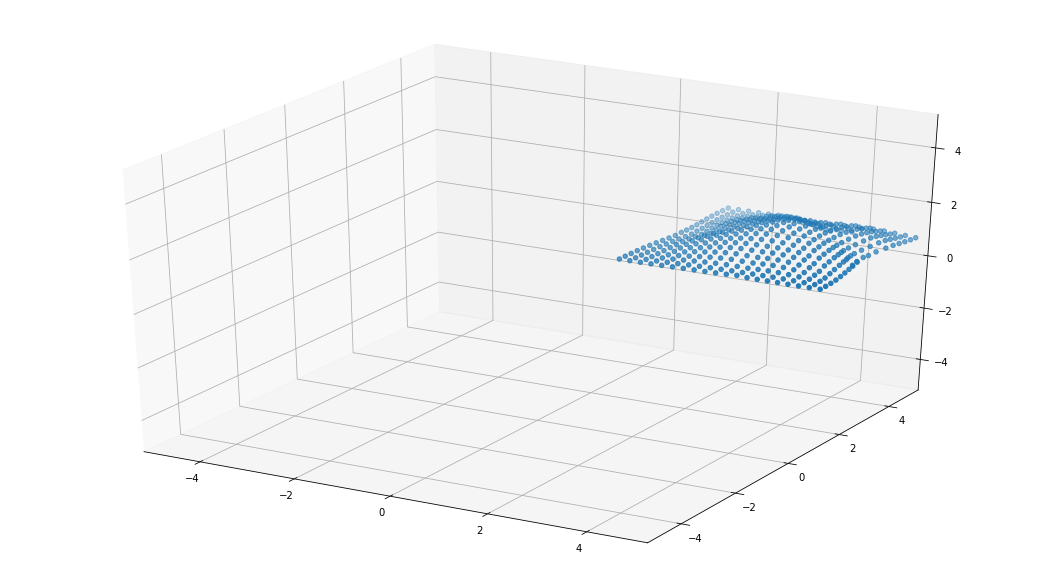

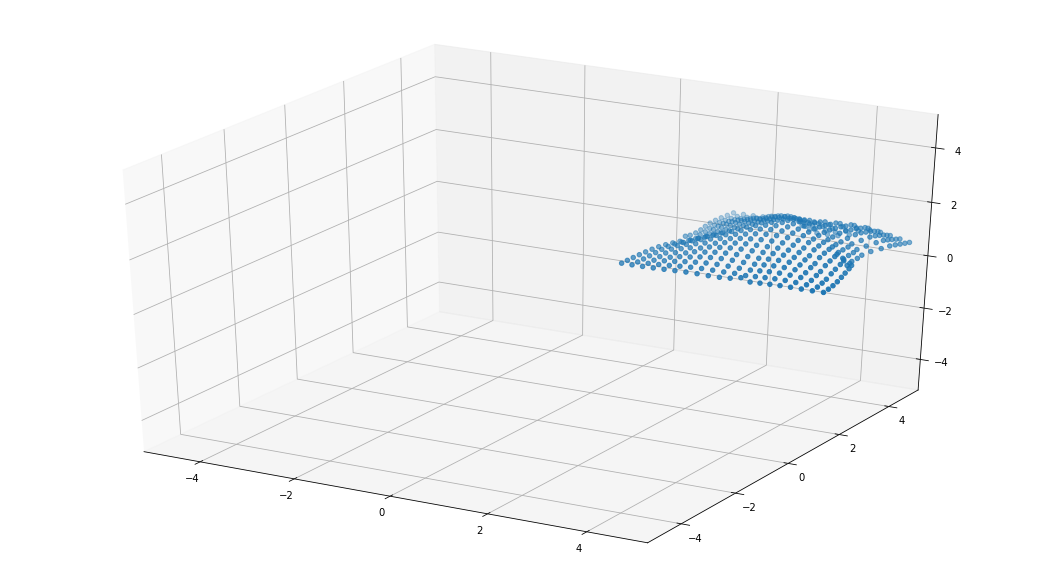

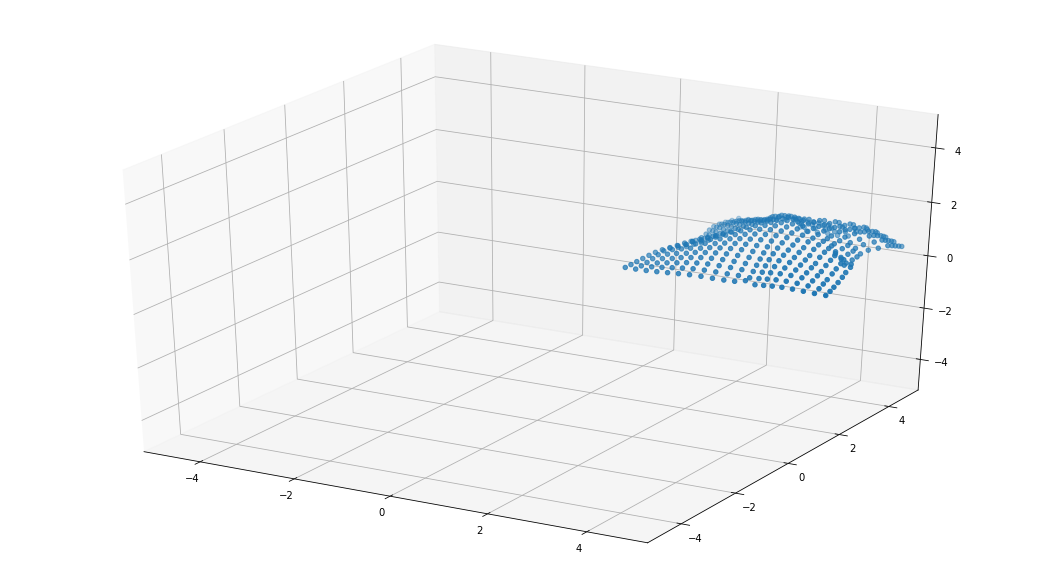

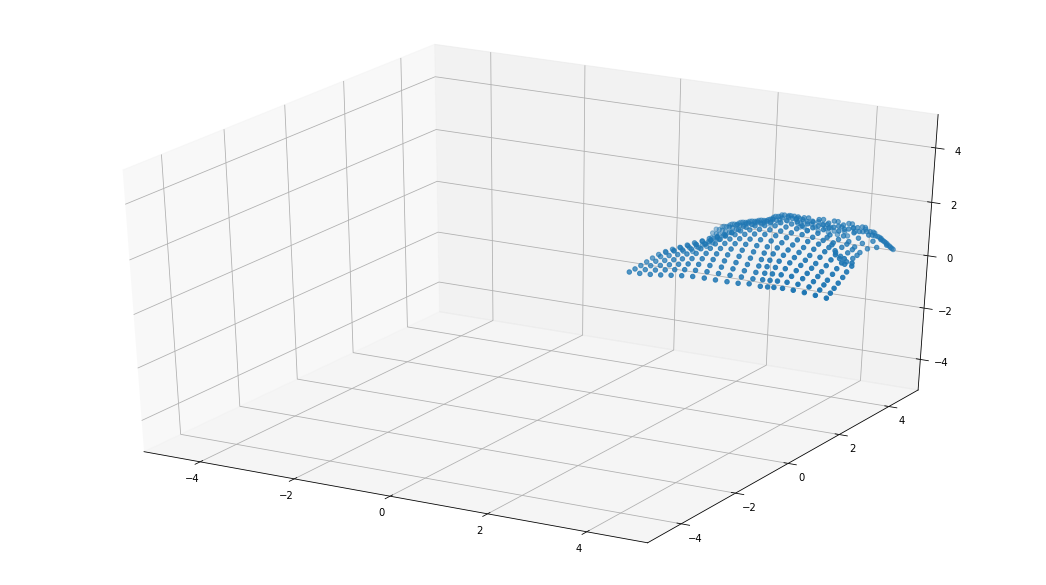

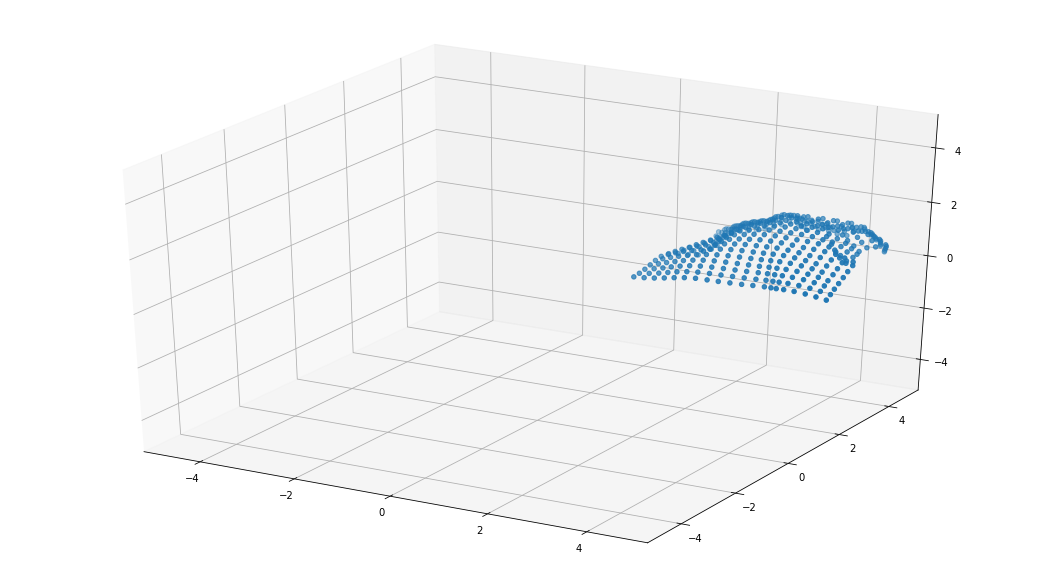

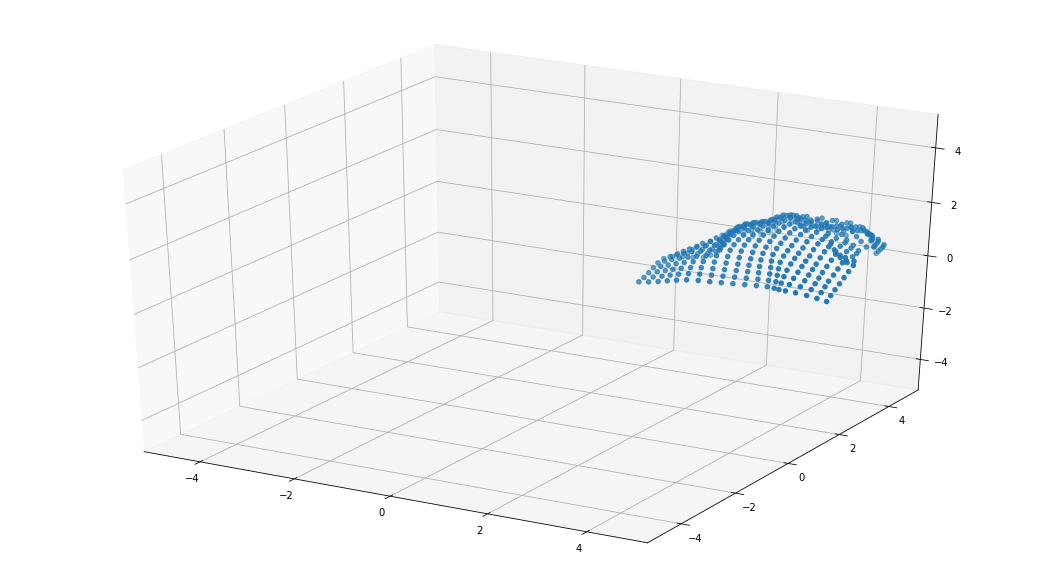

In [325]:
for i in range(20):
  plot_frame(test_x[0][i])